In [1]:
import os, time, math, json, random
from pathlib import Path
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import pennylane as qml
import joblib

# Force float32 everywhere (crucial for GPU performance)
torch.set_default_dtype(torch.float32)

# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)
if DEVICE.type == "cuda":
    torch.set_float32_matmul_precision('high')
    torch.backends.cudnn.benchmark = True

Using device: cuda


In [2]:
# -------------------- QMDN specific --------------------
N_QUBITS = 8                # Start with 8 – adjust based on GPU memory
N_LAYERS = 4                 # Depth of quantum circuit
N_COMPONENTS = 5             # Number of Gaussian mixtures (same as classical MDN)
HIDDEN_DIM = 64              # Classical hidden layer after quantum features

# -------------------- Training --------------------
OUTDIR_BASE = "mdn_70_10_20_optimized"   # same as classical
EN_DIR = os.path.join(OUTDIR_BASE, "qmdn_ensembles_fast")
os.makedirs(EN_DIR, exist_ok=True)

N_SEEDS = 10
SEEDS = [42 + i for i in range(N_SEEDS)]
BATCH_SIZE = 256              # Adjust based on GPU memory
MAX_EPOCHS = 100
PATIENCE = 20
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
CLIP_NORM = 4.0
NUM_WORKERS = 8
PIN_MEMORY = True if DEVICE.type == "cuda" else False
RESUME_IF_EXISTS = True

In [3]:
# -------------------- Load and prepare data --------------------
DRIVE_URL = "https://drive.google.com/uc?id=1PS0eB8dx8VMzVvxNUc6wBzsMRkEKJjWI"
df = pd.read_csv(DRIVE_URL)

# Physics feature engineering (same as before)
M_p = 938.272088; M_n = 939.565420; epsilon=1e-30; LN10=np.log(10.0)

def get_nucleon_mass(Z,A): return Z*M_p + (A-Z)*M_n

mass1 = df.apply(lambda r: get_nucleon_mass(r["Z1"], r["A1"]), axis=1).values
mass2 = df.apply(lambda r: get_nucleon_mass(r["Z2"], r["A2"]), axis=1).values
mu_MeVc2 = (mass1 * mass2) / (mass1 + mass2 + 1e-12)
Ecm = df["E c.m."].astype(float).values
v_over_c = np.sqrt(np.clip(2*Ecm/(mu_MeVc2+epsilon),0,np.inf))
e2_hbar_c = 1/137.035999
df["eta"] = (df["Z1"]*df["Z2"]) / (e2_hbar_c*(v_over_c+1e-16))

log10_sigma_exp = np.log10(np.clip(df["σ"],1e-30,np.inf))
log10_sigma_cal = np.log10(np.clip(df["σ cal"],1e-30,np.inf))
log10_Ecm = np.log10(np.clip(df["E c.m."],1e-30,np.inf))
log10_exp_term = (2*np.pi*df["eta"])/LN10

df["log10_S_exp"] = log10_sigma_exp + log10_Ecm + log10_exp_term
df["log10_S_cal"] = log10_sigma_cal + log10_Ecm + log10_exp_term
df["delta_log10_S"] = df["log10_S_exp"] - df["log10_S_cal"]

df["N1"] = df["A1"] - df["Z1"]
df["N2"] = df["A2"] - df["Z2"]
df["Z1Z2_over_Ecm"] = (df["Z1"]*df["Z2"]) / (df["E c.m."] + epsilon)

MAGIC = np.array([2,8,20,28,50,82,126])
def magic_dist(arr): return np.min(np.abs(arr[:,None] - MAGIC[None,:]),axis=1)

df["magic_dist_Z1"] = magic_dist(df["Z1"].values)
df["magic_dist_N1"] = magic_dist(df["N1"].values)
df["magic_dist_Z2"] = magic_dist(df["Z2"].values)
df["magic_dist_N2"] = magic_dist(df["N2"].values)

# 29 training features
features_train = [
    'E c.m.', 'Z1', 'N1', 'A1',
    'Z2', 'N2', 'A2', 'Q ( 2 n )',
    'Z1Z2_over_Ecm',
    'magic_dist_Z1','magic_dist_N1','magic_dist_Z2','magic_dist_N2',
    'Z3','N3','A3','β P','β T','R B','ħ ω',
    'Projectile_Mass_Actual', 'Target_Mass_Actual', 'Compound_Nucleus_Mass_Actual',
    'Compound_Nucleus_Sp','Compound_Nucleus_Sn',
    'Projectile_Binding_Energy','Target_Binding_Energy',
    'Compound_Nucleus_Binding_Energy','Compound_Nucleus_S2n'
]

# Reaction split
train_file = Path(OUTDIR_BASE)/"train_reactions.csv"
val_file   = Path(OUTDIR_BASE)/"val_reactions.csv"
test_file  = Path(OUTDIR_BASE)/"test_reactions.csv"

if train_file.exists():
    train_reacts = pd.read_csv(train_file)["Reaction"].values
    val_reacts   = pd.read_csv(val_file)["Reaction"].values
    test_reacts  = pd.read_csv(test_file)["Reaction"].values
else:
    reactions = df["Reaction"].unique()
    np.random.seed(42); np.random.shuffle(reactions)
    n = len(reactions)
    train_reacts = reactions[:int(0.7*n)]
    val_reacts   = reactions[int(0.7*n):int(0.8*n)]
    test_reacts  = reactions[int(0.8*n):]
    pd.DataFrame({"Reaction":train_reacts}).to_csv(train_file,index=False)
    pd.DataFrame({"Reaction":val_reacts}).to_csv(val_file,index=False)
    pd.DataFrame({"Reaction":test_reacts}).to_csv(test_file,index=False)

train_mask = df["Reaction"].isin(train_reacts)
val_mask   = df["Reaction"].isin(val_reacts)
test_mask  = df["Reaction"].isin(test_reacts)

# Prepare arrays
X_train_full = df.loc[train_mask|val_mask, features_train].values.astype(np.float32)
y_train_full = df.loc[train_mask|val_mask, "delta_log10_S"].values.astype(np.float32).reshape(-1,1)
X_test = df.loc[test_mask, features_train].values.astype(np.float32)
y_test = df.loc[test_mask, "delta_log10_S"].values.astype(np.float32).reshape(-1,1)

# Standardize
scaler = StandardScaler().fit(X_train_full)
joblib.dump(scaler, os.path.join(EN_DIR,"scaler.pkl"))
X_train_full_s = scaler.transform(X_train_full)
X_test_s       = scaler.transform(X_test)

print(f"Train+Val: {X_train_full_s.shape}, Test: {X_test_s.shape}")

Train+Val: (2847, 29), Test: (685, 29)


In [4]:
# -------------------- PennyLane setup --------------------
# Use default.qubit with backprop – native batching on GPU
dev = qml.device("default.qubit", wires=N_QUBITS)

@qml.qnode(dev, interface="torch", diff_method="backprop")
def qnode(weights, x):
    qml.templates.AngleEmbedding(x, wires=range(N_QUBITS), rotation="X")
    qml.templates.StronglyEntanglingLayers(weights, wires=range(N_QUBITS))
    return qml.probs(wires=range(N_QUBITS))   # shape (2**N_QUBITS,)

In [5]:
class QMDN(nn.Module):
    def __init__(self, in_dim, n_qubits=N_QUBITS, n_layers=N_LAYERS,
                 n_components=N_COMPONENTS, hidden_dim=HIDDEN_DIM):
        super().__init__()
        self.n_qubits = n_qubits
        self.n_components = n_components

        # Classical encoder (29 -> n_qubits)
        self.encoder = nn.Linear(in_dim, n_qubits)

        # Quantum weights
        self.q_weights = nn.Parameter(
            0.01 * torch.randn(n_layers, n_qubits, 3, dtype=torch.float32)
        )

        # Classical post‑processing
        # Quantum output dimension = 2**n_qubits (probabilities)
        self.fc1 = nn.Linear(2**n_qubits, hidden_dim)
        self.fc_pi = nn.Linear(hidden_dim, n_components)
        self.fc_mu = nn.Linear(hidden_dim, n_components)
        self.fc_sigma = nn.Linear(hidden_dim, n_components)

    def forward(self, x):
        x = x.float()
        # Encode to quantum angles
        x_enc = torch.tanh(self.encoder(x))          # (batch, n_qubits)

        # Batched quantum circuit – returns (batch, 2**n_qubits)
        q_probs = qnode(self.q_weights, x_enc)

        # Ensure correct dtype and device
        q_probs = q_probs.to(x.device).float()

        # Classical layers
        h = torch.relu(self.fc1(q_probs))
        pi_logits = self.fc_pi(h)
        mu = self.fc_mu(h)
        sigma_raw = self.fc_sigma(h)

        pi = F.softmax(pi_logits, dim=1)
        sigma = F.softplus(sigma_raw) + 1e-6
        return pi, mu, sigma

In [6]:
def mdn_loss(pi, mu, sigma, y):
    """Negative log‑likelihood of mixture model."""
    y = y.float()
    yexp = y.repeat(1, mu.shape[1])                # (batch, n_components)

    log_gauss = (
        -0.5 * ((yexp - mu) / sigma) ** 2
        - torch.log(sigma)
        - 0.5 * np.log(2 * np.pi)
    )
    log_mix = torch.logsumexp(torch.log(pi + 1e-12) + log_gauss, dim=1)
    return -log_mix.mean()

def mdn_predict_mode(pi, mu, sigma):
    """Most probable component (mode of the mixture)."""
    idx = torch.argmax(pi, dim=1)
    return mu[torch.arange(len(idx)), idx].unsqueeze(1)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

def make_loader(X, y, batch=BATCH_SIZE, shuffle=True):
    dataset = TensorDataset(torch.tensor(X), torch.tensor(y))
    return DataLoader(
        dataset,
        batch_size=batch,
        shuffle=shuffle,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        persistent_workers=(NUM_WORKERS > 0),
        worker_init_fn=seed_worker
    )

In [8]:
# -------------------- Ensemble storage --------------------
all_preds = []          # store test predictions for each seed
all_test_components = []  # store (pi, mu, sigma) for test set per seed

for seed in SEEDS:
    print("\n" + "="*50)
    print(f"Seed {seed}")
    print("="*50)

    # Seed everything
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    # Prepare per‑seed directory
    seed_dir = os.path.join(EN_DIR, f"seed_{seed}")
    os.makedirs(seed_dir, exist_ok=True)
    ckpt_path = os.path.join(seed_dir, "qmdn_best.pth")
    test_comp_path = os.path.join(seed_dir, "test_components.npz")

    # Split train into train/val (5% validation)
    n_all = len(X_train_full_s)
    perm = np.random.permutation(n_all)
    val_size = max(int(0.05 * n_all), 1)
    tr_idx = perm[val_size:]
    val_idx = perm[:val_size]

    train_loader = make_loader(X_train_full_s[tr_idx], y_train_full[tr_idx], shuffle=True)
    val_loader   = make_loader(X_train_full_s[val_idx], y_train_full[val_idx], shuffle=False)

    # Model (no compile!)
    model = QMDN(in_dim=X_train_full_s.shape[1]).to(DEVICE)

    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                            factor=0.5, patience=10)

    best_val_loss = float('inf')
    patience_counter = 0

    # Resume if exists
    if RESUME_IF_EXISTS and os.path.exists(ckpt_path):
        try:
            saved = torch.load(ckpt_path, map_location='cpu')
            model.load_state_dict(saved['state'])
            best_val_loss = saved['best_val']
            print(f"Resumed from {ckpt_path}, best val loss = {best_val_loss:.6f}")
        except Exception as e:
            print(f"Resume failed: {e}")

    # ---------- Training (full precision, no AMP) ----------
    for epoch in range(MAX_EPOCHS):
        model.train()
        epoch_loss = 0.0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch}", leave=False)

        for xb, yb in pbar:
            xb = xb.to(DEVICE).float()
            yb = yb.to(DEVICE).float()
            optimizer.zero_grad()

            # Forward + loss (standard float32)
            pi, mu, sigma = model(xb)
            loss = mdn_loss(pi, mu, sigma, yb)

            # Backward
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)

            # Optimizer step
            optimizer.step()

            epoch_loss += loss.item() * xb.size(0)
            pbar.set_postfix({'loss': f"{epoch_loss / len(train_loader.dataset):.4f}"})

        epoch_loss /= len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(DEVICE).float()
                yb = yb.to(DEVICE).float()
                pi, mu, sigma = model(xb)
                val_loss += mdn_loss(pi, mu, sigma, yb).item() * xb.size(0)
        val_loss /= len(val_loader.dataset)

        scheduler.step(val_loss)

        tqdm.write(f"Seed {seed} | Epoch {epoch:3d} | Train Loss: {epoch_loss:.6f} | Val Loss: {val_loss:.6f}")

        # Early stopping
        if val_loss < best_val_loss - 1e-9:
            best_val_loss = val_loss
            torch.save({'state': model.state_dict(), 'best_val': best_val_loss}, ckpt_path)
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print(f"Early stopping at epoch {epoch}")
                break

    # ---------- Test evaluation (unchanged) ----------
    print(f"Loading best model for seed {seed}...")
    saved = torch.load(ckpt_path, map_location=DEVICE)
    model.load_state_dict(saved['state'])
    model.eval()

    test_loader = make_loader(X_test_s, y_test, shuffle=False)

    preds_list = []
    pi_list = []
    mu_list = []
    sigma_list = []

    with torch.no_grad():
        for xb, _ in tqdm(test_loader, desc="Testing", leave=False):
            xb = xb.to(DEVICE).float()
            pi, mu, sigma = model(xb)
            pred = mdn_predict_mode(pi, mu, sigma)
            preds_list.append(pred.cpu().numpy())
            pi_list.append(pi.cpu().numpy())
            mu_list.append(mu.cpu().numpy())
            sigma_list.append(sigma.cpu().numpy())

    preds_arr = np.vstack(preds_list).flatten()
    all_preds.append(preds_arr)

    # Save test components
    np.savez(test_comp_path,
             pi=np.vstack(pi_list),
             mu=np.vstack(mu_list),
             sigma=np.vstack(sigma_list))
    all_test_components.append((np.vstack(pi_list), np.vstack(mu_list), np.vstack(sigma_list)))

    rmse = np.sqrt(mean_squared_error(y_test.flatten(), preds_arr))
    print(f"Seed {seed} | Test RMSE: {rmse:.4f}")

    # ---------- Full dataset inference (unchanged) ----------
    print("Computing components on full dataset...")
    full_loader = make_loader(scaler.transform(df[features_train].values.astype(np.float32)),
                               np.zeros((len(df), 1)), shuffle=False)
    pi_full, mu_full, sigma_full = [], [], []
    with torch.no_grad():
        for xb, _ in tqdm(full_loader, desc="Full data", leave=False):
            xb = xb.to(DEVICE).float()
            pi, mu, sigma = model(xb)
            pi_full.append(pi.cpu().numpy())
            mu_full.append(mu.cpu().numpy())
            sigma_full.append(sigma.cpu().numpy())
    np.savez(os.path.join(seed_dir, "full_components.npz"),
             pi=np.vstack(pi_full), mu=np.vstack(mu_full), sigma=np.vstack(sigma_full))


Seed 42


Epoch 0:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch   0 | Train Loss: 0.619496 | Val Loss: 0.646252


Epoch 1:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch   1 | Train Loss: 0.587309 | Val Loss: 0.613744


Epoch 2:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch   2 | Train Loss: 0.546074 | Val Loss: 0.571755


Epoch 3:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch   3 | Train Loss: 0.490541 | Val Loss: 0.516220


Epoch 4:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch   4 | Train Loss: 0.417446 | Val Loss: 0.447156


Epoch 5:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch   5 | Train Loss: 0.324543 | Val Loss: 0.369718


Epoch 6:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch   6 | Train Loss: 0.218620 | Val Loss: 0.294498


Epoch 7:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch   7 | Train Loss: 0.109928 | Val Loss: 0.216028


Epoch 8:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch   8 | Train Loss: -0.013180 | Val Loss: 0.124513


Epoch 9:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch   9 | Train Loss: -0.120591 | Val Loss: 0.056098


Epoch 10:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  10 | Train Loss: -0.197501 | Val Loss: 0.013959


Epoch 11:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  11 | Train Loss: -0.235012 | Val Loss: -0.026379


Epoch 12:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  12 | Train Loss: -0.268739 | Val Loss: -0.067333


Epoch 13:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  13 | Train Loss: -0.299837 | Val Loss: -0.108828


Epoch 14:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  14 | Train Loss: -0.335915 | Val Loss: -0.149967


Epoch 15:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  15 | Train Loss: -0.371143 | Val Loss: -0.200919


Epoch 16:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  16 | Train Loss: -0.403785 | Val Loss: -0.241980


Epoch 17:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  17 | Train Loss: -0.433123 | Val Loss: -0.285702


Epoch 18:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  18 | Train Loss: -0.461778 | Val Loss: -0.323630


Epoch 19:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  19 | Train Loss: -0.483997 | Val Loss: -0.342817


Epoch 20:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  20 | Train Loss: -0.504485 | Val Loss: -0.371426


Epoch 21:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  21 | Train Loss: -0.531257 | Val Loss: -0.386161


Epoch 22:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  22 | Train Loss: -0.549134 | Val Loss: -0.396973


Epoch 23:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  23 | Train Loss: -0.569228 | Val Loss: -0.411764


Epoch 24:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  24 | Train Loss: -0.588238 | Val Loss: -0.424898


Epoch 25:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  25 | Train Loss: -0.600172 | Val Loss: -0.429578


Epoch 26:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  26 | Train Loss: -0.613825 | Val Loss: -0.442731


Epoch 27:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  27 | Train Loss: -0.626095 | Val Loss: -0.442673


Epoch 28:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  28 | Train Loss: -0.638864 | Val Loss: -0.458362


Epoch 29:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  29 | Train Loss: -0.648769 | Val Loss: -0.461870


Epoch 30:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  30 | Train Loss: -0.660634 | Val Loss: -0.473592


Epoch 31:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  31 | Train Loss: -0.671188 | Val Loss: -0.473778


Epoch 32:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  32 | Train Loss: -0.677773 | Val Loss: -0.474984


Epoch 33:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  33 | Train Loss: -0.681925 | Val Loss: -0.479962


Epoch 34:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  34 | Train Loss: -0.698051 | Val Loss: -0.499770


Epoch 35:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  35 | Train Loss: -0.705040 | Val Loss: -0.485809


Epoch 36:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  36 | Train Loss: -0.712752 | Val Loss: -0.502431


Epoch 37:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  37 | Train Loss: -0.710951 | Val Loss: -0.508335


Epoch 38:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  38 | Train Loss: -0.723938 | Val Loss: -0.512340


Epoch 39:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  39 | Train Loss: -0.735600 | Val Loss: -0.513720


Epoch 40:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  40 | Train Loss: -0.741304 | Val Loss: -0.502338


Epoch 41:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  41 | Train Loss: -0.751817 | Val Loss: -0.522892


Epoch 42:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  42 | Train Loss: -0.755840 | Val Loss: -0.536995


Epoch 43:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  43 | Train Loss: -0.762303 | Val Loss: -0.539490


Epoch 44:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  44 | Train Loss: -0.764479 | Val Loss: -0.555411


Epoch 45:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  45 | Train Loss: -0.764906 | Val Loss: -0.556455


Epoch 46:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  46 | Train Loss: -0.778214 | Val Loss: -0.559221


Epoch 47:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  47 | Train Loss: -0.781245 | Val Loss: -0.555129


Epoch 48:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  48 | Train Loss: -0.787508 | Val Loss: -0.567634


Epoch 49:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  49 | Train Loss: -0.790068 | Val Loss: -0.555989


Epoch 50:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  50 | Train Loss: -0.799600 | Val Loss: -0.551877


Epoch 51:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  51 | Train Loss: -0.798580 | Val Loss: -0.562546


Epoch 52:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  52 | Train Loss: -0.803545 | Val Loss: -0.578967


Epoch 53:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  53 | Train Loss: -0.801118 | Val Loss: -0.570873


Epoch 54:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  54 | Train Loss: -0.791431 | Val Loss: -0.573534


Epoch 55:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  55 | Train Loss: -0.804590 | Val Loss: -0.586272


Epoch 56:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  56 | Train Loss: -0.818084 | Val Loss: -0.558171


Epoch 57:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  57 | Train Loss: -0.817564 | Val Loss: -0.590226


Epoch 58:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  58 | Train Loss: -0.822710 | Val Loss: -0.576456


Epoch 59:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  59 | Train Loss: -0.828619 | Val Loss: -0.587571


Epoch 60:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  60 | Train Loss: -0.832870 | Val Loss: -0.590052


Epoch 61:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  61 | Train Loss: -0.836436 | Val Loss: -0.610006


Epoch 62:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  62 | Train Loss: -0.834475 | Val Loss: -0.575305


Epoch 63:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  63 | Train Loss: -0.844831 | Val Loss: -0.608195


Epoch 64:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  64 | Train Loss: -0.848072 | Val Loss: -0.579922


Epoch 65:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  65 | Train Loss: -0.838954 | Val Loss: -0.559018


Epoch 66:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  66 | Train Loss: -0.844481 | Val Loss: -0.583962


Epoch 67:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  67 | Train Loss: -0.859637 | Val Loss: -0.609552


Epoch 68:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  68 | Train Loss: -0.854554 | Val Loss: -0.620759


Epoch 69:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  69 | Train Loss: -0.863675 | Val Loss: -0.631106


Epoch 70:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  70 | Train Loss: -0.869484 | Val Loss: -0.615174


Epoch 71:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  71 | Train Loss: -0.874948 | Val Loss: -0.624015


Epoch 72:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  72 | Train Loss: -0.876311 | Val Loss: -0.620481


Epoch 73:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  73 | Train Loss: -0.878192 | Val Loss: -0.612678


Epoch 74:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  74 | Train Loss: -0.884837 | Val Loss: -0.634077


Epoch 75:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  75 | Train Loss: -0.886771 | Val Loss: -0.614019


Epoch 76:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  76 | Train Loss: -0.893840 | Val Loss: -0.636201


Epoch 77:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  77 | Train Loss: -0.896213 | Val Loss: -0.616243


Epoch 78:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  78 | Train Loss: -0.900872 | Val Loss: -0.655622


Epoch 79:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  79 | Train Loss: -0.880622 | Val Loss: -0.639745


Epoch 80:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  80 | Train Loss: -0.887328 | Val Loss: -0.656209


Epoch 81:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  81 | Train Loss: -0.909074 | Val Loss: -0.661023


Epoch 82:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  82 | Train Loss: -0.915298 | Val Loss: -0.631821


Epoch 83:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  83 | Train Loss: -0.917580 | Val Loss: -0.669472


Epoch 84:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  84 | Train Loss: -0.921145 | Val Loss: -0.643708


Epoch 85:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  85 | Train Loss: -0.930725 | Val Loss: -0.665231


Epoch 86:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  86 | Train Loss: -0.932644 | Val Loss: -0.676381


Epoch 87:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  87 | Train Loss: -0.934472 | Val Loss: -0.684804


Epoch 88:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  88 | Train Loss: -0.933827 | Val Loss: -0.708411


Epoch 89:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  89 | Train Loss: -0.943809 | Val Loss: -0.654014


Epoch 90:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  90 | Train Loss: -0.944984 | Val Loss: -0.675582


Epoch 91:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  91 | Train Loss: -0.955429 | Val Loss: -0.683560


Epoch 92:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  92 | Train Loss: -0.956190 | Val Loss: -0.674875


Epoch 93:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  93 | Train Loss: -0.963267 | Val Loss: -0.696369


Epoch 94:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  94 | Train Loss: -0.965132 | Val Loss: -0.701581


Epoch 95:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  95 | Train Loss: -0.969589 | Val Loss: -0.689097


Epoch 96:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  96 | Train Loss: -0.974121 | Val Loss: -0.708135


Epoch 97:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  97 | Train Loss: -0.977748 | Val Loss: -0.711085


Epoch 98:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  98 | Train Loss: -0.983335 | Val Loss: -0.709143


Epoch 99:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 42 | Epoch  99 | Train Loss: -0.989977 | Val Loss: -0.691356
Loading best model for seed 42...


/tmp/ipykernel_73454/3157134035.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved = torch.load(ckpt_path, map_location=DEVICE)


Testing:   0%|          | 0/3 [00:00<?, ?it/s]

Seed 42 | Test RMSE: 0.2367
Computing components on full dataset...


Full data:   0%|          | 0/14 [00:00<?, ?it/s]


Seed 43


Epoch 0:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch   0 | Train Loss: 0.621502 | Val Loss: 0.606642


Epoch 1:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch   1 | Train Loss: 0.582393 | Val Loss: 0.561540


Epoch 2:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch   2 | Train Loss: 0.531744 | Val Loss: 0.502796


Epoch 3:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch   3 | Train Loss: 0.466317 | Val Loss: 0.427013


Epoch 4:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch   4 | Train Loss: 0.382478 | Val Loss: 0.335416


Epoch 5:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch   5 | Train Loss: 0.281824 | Val Loss: 0.233376


Epoch 6:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch   6 | Train Loss: 0.175362 | Val Loss: 0.124689


Epoch 7:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch   7 | Train Loss: 0.060166 | Val Loss: 0.021939


Epoch 8:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch   8 | Train Loss: -0.051006 | Val Loss: -0.058550


Epoch 9:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch   9 | Train Loss: -0.139962 | Val Loss: -0.109865


Epoch 10:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  10 | Train Loss: -0.188346 | Val Loss: -0.167444


Epoch 11:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  11 | Train Loss: -0.225671 | Val Loss: -0.207022


Epoch 12:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  12 | Train Loss: -0.256585 | Val Loss: -0.236847


Epoch 13:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  13 | Train Loss: -0.285351 | Val Loss: -0.266240


Epoch 14:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  14 | Train Loss: -0.301095 | Val Loss: -0.252104


Epoch 15:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  15 | Train Loss: -0.319404 | Val Loss: -0.312568


Epoch 16:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  16 | Train Loss: -0.344802 | Val Loss: -0.340615


Epoch 17:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  17 | Train Loss: -0.372769 | Val Loss: -0.369084


Epoch 18:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  18 | Train Loss: -0.402106 | Val Loss: -0.403261


Epoch 19:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  19 | Train Loss: -0.437362 | Val Loss: -0.435531


Epoch 20:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  20 | Train Loss: -0.474781 | Val Loss: -0.472933


Epoch 21:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  21 | Train Loss: -0.507994 | Val Loss: -0.509433


Epoch 22:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  22 | Train Loss: -0.541058 | Val Loss: -0.541513


Epoch 23:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  23 | Train Loss: -0.571204 | Val Loss: -0.556544


Epoch 24:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  24 | Train Loss: -0.595900 | Val Loss: -0.563399


Epoch 25:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  25 | Train Loss: -0.617465 | Val Loss: -0.588829


Epoch 26:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  26 | Train Loss: -0.636406 | Val Loss: -0.621135


Epoch 27:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  27 | Train Loss: -0.656217 | Val Loss: -0.622654


Epoch 28:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  28 | Train Loss: -0.670832 | Val Loss: -0.642210


Epoch 29:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  29 | Train Loss: -0.682433 | Val Loss: -0.646718


Epoch 30:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  30 | Train Loss: -0.692828 | Val Loss: -0.652051


Epoch 31:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  31 | Train Loss: -0.702929 | Val Loss: -0.668786


Epoch 32:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  32 | Train Loss: -0.708871 | Val Loss: -0.689799


Epoch 33:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  33 | Train Loss: -0.716711 | Val Loss: -0.662355


Epoch 34:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  34 | Train Loss: -0.727606 | Val Loss: -0.694458


Epoch 35:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  35 | Train Loss: -0.726663 | Val Loss: -0.688558


Epoch 36:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  36 | Train Loss: -0.727127 | Val Loss: -0.708418


Epoch 37:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  37 | Train Loss: -0.739587 | Val Loss: -0.705874


Epoch 38:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  38 | Train Loss: -0.749821 | Val Loss: -0.704583


Epoch 39:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  39 | Train Loss: -0.756762 | Val Loss: -0.715197


Epoch 40:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  40 | Train Loss: -0.758868 | Val Loss: -0.723542


Epoch 41:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  41 | Train Loss: -0.764626 | Val Loss: -0.734863


Epoch 42:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  42 | Train Loss: -0.771567 | Val Loss: -0.735995


Epoch 43:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  43 | Train Loss: -0.776145 | Val Loss: -0.748810


Epoch 44:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  44 | Train Loss: -0.774258 | Val Loss: -0.732070


Epoch 45:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  45 | Train Loss: -0.782720 | Val Loss: -0.759409


Epoch 46:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  46 | Train Loss: -0.791019 | Val Loss: -0.750518


Epoch 47:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  47 | Train Loss: -0.790958 | Val Loss: -0.744775


Epoch 48:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  48 | Train Loss: -0.791735 | Val Loss: -0.747284


Epoch 49:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  49 | Train Loss: -0.803415 | Val Loss: -0.789756


Epoch 50:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  50 | Train Loss: -0.804050 | Val Loss: -0.776687


Epoch 51:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  51 | Train Loss: -0.811464 | Val Loss: -0.784566


Epoch 52:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  52 | Train Loss: -0.815861 | Val Loss: -0.795050


Epoch 53:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  53 | Train Loss: -0.810041 | Val Loss: -0.789095


Epoch 54:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  54 | Train Loss: -0.825001 | Val Loss: -0.811074


Epoch 55:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  55 | Train Loss: -0.827886 | Val Loss: -0.800010


Epoch 56:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  56 | Train Loss: -0.831934 | Val Loss: -0.831710


Epoch 57:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  57 | Train Loss: -0.837531 | Val Loss: -0.805326


Epoch 58:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  58 | Train Loss: -0.841106 | Val Loss: -0.821603


Epoch 59:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  59 | Train Loss: -0.839180 | Val Loss: -0.818954


Epoch 60:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  60 | Train Loss: -0.847598 | Val Loss: -0.826620


Epoch 61:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  61 | Train Loss: -0.847618 | Val Loss: -0.821300


Epoch 62:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  62 | Train Loss: -0.856033 | Val Loss: -0.839550


Epoch 63:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  63 | Train Loss: -0.857395 | Val Loss: -0.839297


Epoch 64:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  64 | Train Loss: -0.861386 | Val Loss: -0.841350


Epoch 65:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  65 | Train Loss: -0.860399 | Val Loss: -0.859988


Epoch 66:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  66 | Train Loss: -0.869244 | Val Loss: -0.856202


Epoch 67:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  67 | Train Loss: -0.867419 | Val Loss: -0.789839


Epoch 68:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  68 | Train Loss: -0.851631 | Val Loss: -0.804563


Epoch 69:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  69 | Train Loss: -0.855259 | Val Loss: -0.842585


Epoch 70:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  70 | Train Loss: -0.868209 | Val Loss: -0.846000


Epoch 71:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  71 | Train Loss: -0.880273 | Val Loss: -0.853577


Epoch 72:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  72 | Train Loss: -0.883491 | Val Loss: -0.857616


Epoch 73:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  73 | Train Loss: -0.881385 | Val Loss: -0.872887


Epoch 74:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  74 | Train Loss: -0.887269 | Val Loss: -0.866639


Epoch 75:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  75 | Train Loss: -0.879033 | Val Loss: -0.858285


Epoch 76:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  76 | Train Loss: -0.889071 | Val Loss: -0.897109


Epoch 77:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  77 | Train Loss: -0.894665 | Val Loss: -0.874453


Epoch 78:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  78 | Train Loss: -0.892832 | Val Loss: -0.874511


Epoch 79:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  79 | Train Loss: -0.901746 | Val Loss: -0.887088


Epoch 80:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  80 | Train Loss: -0.896387 | Val Loss: -0.876119


Epoch 81:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  81 | Train Loss: -0.889072 | Val Loss: -0.886176


Epoch 82:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  82 | Train Loss: -0.905266 | Val Loss: -0.866720


Epoch 83:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  83 | Train Loss: -0.910791 | Val Loss: -0.894932


Epoch 84:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  84 | Train Loss: -0.911843 | Val Loss: -0.880128


Epoch 85:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  85 | Train Loss: -0.911210 | Val Loss: -0.903003


Epoch 86:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  86 | Train Loss: -0.918308 | Val Loss: -0.892824


Epoch 87:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  87 | Train Loss: -0.921091 | Val Loss: -0.900488


Epoch 88:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  88 | Train Loss: -0.921138 | Val Loss: -0.912081


Epoch 89:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  89 | Train Loss: -0.915892 | Val Loss: -0.900035


Epoch 90:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  90 | Train Loss: -0.926081 | Val Loss: -0.896436


Epoch 91:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  91 | Train Loss: -0.921030 | Val Loss: -0.922229


Epoch 92:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  92 | Train Loss: -0.927264 | Val Loss: -0.916125


Epoch 93:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  93 | Train Loss: -0.933584 | Val Loss: -0.930688


Epoch 94:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  94 | Train Loss: -0.939017 | Val Loss: -0.923974


Epoch 95:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  95 | Train Loss: -0.934335 | Val Loss: -0.935159


Epoch 96:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  96 | Train Loss: -0.910542 | Val Loss: -0.915226


Epoch 97:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  97 | Train Loss: -0.934756 | Val Loss: -0.939620


Epoch 98:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  98 | Train Loss: -0.943255 | Val Loss: -0.921099


Epoch 99:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 43 | Epoch  99 | Train Loss: -0.946934 | Val Loss: -0.940160
Loading best model for seed 43...


/tmp/ipykernel_73454/3157134035.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved = torch.load(ckpt_path, map_location=DEVICE)


Testing:   0%|          | 0/3 [00:00<?, ?it/s]

Seed 43 | Test RMSE: 0.2257
Computing components on full dataset...


Full data:   0%|          | 0/14 [00:00<?, ?it/s]


Seed 44


Epoch 0:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch   0 | Train Loss: 0.626447 | Val Loss: 0.657898


Epoch 1:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch   1 | Train Loss: 0.598658 | Val Loss: 0.629511


Epoch 2:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch   2 | Train Loss: 0.564244 | Val Loss: 0.593129


Epoch 3:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch   3 | Train Loss: 0.518393 | Val Loss: 0.545563


Epoch 4:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch   4 | Train Loss: 0.456056 | Val Loss: 0.486984


Epoch 5:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch   5 | Train Loss: 0.378015 | Val Loss: 0.420188


Epoch 6:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch   6 | Train Loss: 0.284646 | Val Loss: 0.354203


Epoch 7:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch   7 | Train Loss: 0.178764 | Val Loss: 0.273519


Epoch 8:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch   8 | Train Loss: 0.062491 | Val Loss: 0.164241


Epoch 9:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch   9 | Train Loss: -0.052077 | Val Loss: 0.054072


Epoch 10:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  10 | Train Loss: -0.126826 | Val Loss: -0.014636


Epoch 11:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  11 | Train Loss: -0.178907 | Val Loss: -0.105057


Epoch 12:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  12 | Train Loss: -0.219241 | Val Loss: -0.157218


Epoch 13:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  13 | Train Loss: -0.249535 | Val Loss: -0.190131


Epoch 14:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  14 | Train Loss: -0.273630 | Val Loss: -0.206011


Epoch 15:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  15 | Train Loss: -0.286834 | Val Loss: -0.215742


Epoch 16:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  16 | Train Loss: -0.317910 | Val Loss: -0.231866


Epoch 17:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  17 | Train Loss: -0.342083 | Val Loss: -0.286943


Epoch 18:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  18 | Train Loss: -0.375086 | Val Loss: -0.326937


Epoch 19:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  19 | Train Loss: -0.398168 | Val Loss: -0.367862


Epoch 20:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  20 | Train Loss: -0.421078 | Val Loss: -0.401353


Epoch 21:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  21 | Train Loss: -0.450341 | Val Loss: -0.434897


Epoch 22:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  22 | Train Loss: -0.469435 | Val Loss: -0.462080


Epoch 23:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  23 | Train Loss: -0.492872 | Val Loss: -0.481260


Epoch 24:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  24 | Train Loss: -0.515354 | Val Loss: -0.497679


Epoch 25:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  25 | Train Loss: -0.535964 | Val Loss: -0.524628


Epoch 26:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  26 | Train Loss: -0.557211 | Val Loss: -0.542193


Epoch 27:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  27 | Train Loss: -0.573671 | Val Loss: -0.571002


Epoch 28:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  28 | Train Loss: -0.591139 | Val Loss: -0.595189


Epoch 29:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  29 | Train Loss: -0.601351 | Val Loss: -0.611112


Epoch 30:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  30 | Train Loss: -0.610841 | Val Loss: -0.627139


Epoch 31:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  31 | Train Loss: -0.617665 | Val Loss: -0.636095


Epoch 32:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  32 | Train Loss: -0.628833 | Val Loss: -0.646729


Epoch 33:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  33 | Train Loss: -0.641462 | Val Loss: -0.662783


Epoch 34:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  34 | Train Loss: -0.655276 | Val Loss: -0.663945


Epoch 35:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  35 | Train Loss: -0.665097 | Val Loss: -0.685238


Epoch 36:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  36 | Train Loss: -0.669069 | Val Loss: -0.693471


Epoch 37:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  37 | Train Loss: -0.678079 | Val Loss: -0.699166


Epoch 38:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  38 | Train Loss: -0.690117 | Val Loss: -0.712512


Epoch 39:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  39 | Train Loss: -0.697393 | Val Loss: -0.716168


Epoch 40:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  40 | Train Loss: -0.702113 | Val Loss: -0.707668


Epoch 41:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  41 | Train Loss: -0.712431 | Val Loss: -0.708211


Epoch 42:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  42 | Train Loss: -0.717278 | Val Loss: -0.642233


Epoch 43:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  43 | Train Loss: -0.715113 | Val Loss: -0.665329


Epoch 44:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  44 | Train Loss: -0.726259 | Val Loss: -0.725813


Epoch 45:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  45 | Train Loss: -0.730421 | Val Loss: -0.677636


Epoch 46:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  46 | Train Loss: -0.733849 | Val Loss: -0.666830


Epoch 47:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  47 | Train Loss: -0.727749 | Val Loss: -0.698461


Epoch 48:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  48 | Train Loss: -0.733787 | Val Loss: -0.760496


Epoch 49:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  49 | Train Loss: -0.756755 | Val Loss: -0.736763


Epoch 50:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  50 | Train Loss: -0.752618 | Val Loss: -0.717903


Epoch 51:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  51 | Train Loss: -0.756007 | Val Loss: -0.747462


Epoch 52:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  52 | Train Loss: -0.771394 | Val Loss: -0.756932


Epoch 53:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  53 | Train Loss: -0.776299 | Val Loss: -0.767139


Epoch 54:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  54 | Train Loss: -0.783850 | Val Loss: -0.786941


Epoch 55:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  55 | Train Loss: -0.790142 | Val Loss: -0.781830


Epoch 56:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  56 | Train Loss: -0.789600 | Val Loss: -0.782010


Epoch 57:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  57 | Train Loss: -0.798037 | Val Loss: -0.801815


Epoch 58:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  58 | Train Loss: -0.800028 | Val Loss: -0.801813


Epoch 59:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  59 | Train Loss: -0.810950 | Val Loss: -0.807148


Epoch 60:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  60 | Train Loss: -0.811339 | Val Loss: -0.809907


Epoch 61:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  61 | Train Loss: -0.821109 | Val Loss: -0.817658


Epoch 62:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  62 | Train Loss: -0.824877 | Val Loss: -0.811657


Epoch 63:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  63 | Train Loss: -0.832083 | Val Loss: -0.776664


Epoch 64:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  64 | Train Loss: -0.815791 | Val Loss: -0.796943


Epoch 65:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  65 | Train Loss: -0.833264 | Val Loss: -0.752068


Epoch 66:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  66 | Train Loss: -0.829641 | Val Loss: -0.804257


Epoch 67:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  67 | Train Loss: -0.844169 | Val Loss: -0.840510


Epoch 68:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  68 | Train Loss: -0.851470 | Val Loss: -0.845888


Epoch 69:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  69 | Train Loss: -0.853746 | Val Loss: -0.834536


Epoch 70:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  70 | Train Loss: -0.857412 | Val Loss: -0.806399


Epoch 71:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  71 | Train Loss: -0.858669 | Val Loss: -0.816149


Epoch 72:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  72 | Train Loss: -0.868533 | Val Loss: -0.838071


Epoch 73:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  73 | Train Loss: -0.871925 | Val Loss: -0.857670


Epoch 74:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  74 | Train Loss: -0.879116 | Val Loss: -0.841662


Epoch 75:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  75 | Train Loss: -0.875304 | Val Loss: -0.856059


Epoch 76:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  76 | Train Loss: -0.889881 | Val Loss: -0.863798


Epoch 77:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  77 | Train Loss: -0.892743 | Val Loss: -0.869115


Epoch 78:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  78 | Train Loss: -0.897845 | Val Loss: -0.828965


Epoch 79:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  79 | Train Loss: -0.890838 | Val Loss: -0.813852


Epoch 80:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  80 | Train Loss: -0.898949 | Val Loss: -0.776714


Epoch 81:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  81 | Train Loss: -0.890618 | Val Loss: -0.818504


Epoch 82:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  82 | Train Loss: -0.898424 | Val Loss: -0.821945


Epoch 83:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  83 | Train Loss: -0.903377 | Val Loss: -0.864595


Epoch 84:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  84 | Train Loss: -0.911368 | Val Loss: -0.903644


Epoch 85:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  85 | Train Loss: -0.919171 | Val Loss: -0.860818


Epoch 86:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  86 | Train Loss: -0.919223 | Val Loss: -0.887496


Epoch 87:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  87 | Train Loss: -0.923986 | Val Loss: -0.885504


Epoch 88:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  88 | Train Loss: -0.928856 | Val Loss: -0.876263


Epoch 89:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  89 | Train Loss: -0.931412 | Val Loss: -0.893885


Epoch 90:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  90 | Train Loss: -0.930166 | Val Loss: -0.882940


Epoch 91:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  91 | Train Loss: -0.930498 | Val Loss: -0.899017


Epoch 92:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  92 | Train Loss: -0.930993 | Val Loss: -0.915703


Epoch 93:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  93 | Train Loss: -0.936667 | Val Loss: -0.868033


Epoch 94:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  94 | Train Loss: -0.943673 | Val Loss: -0.901588


Epoch 95:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  95 | Train Loss: -0.938041 | Val Loss: -0.900841


Epoch 96:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  96 | Train Loss: -0.953542 | Val Loss: -0.925716


Epoch 97:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  97 | Train Loss: -0.951731 | Val Loss: -0.918381


Epoch 98:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  98 | Train Loss: -0.957567 | Val Loss: -0.919684


Epoch 99:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 44 | Epoch  99 | Train Loss: -0.959943 | Val Loss: -0.863970
Loading best model for seed 44...


/tmp/ipykernel_73454/3157134035.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved = torch.load(ckpt_path, map_location=DEVICE)


Testing:   0%|          | 0/3 [00:00<?, ?it/s]

Seed 44 | Test RMSE: 0.2168
Computing components on full dataset...


Full data:   0%|          | 0/14 [00:00<?, ?it/s]


Seed 45


Epoch 0:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch   0 | Train Loss: 0.620039 | Val Loss: 0.595341


Epoch 1:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch   1 | Train Loss: 0.590696 | Val Loss: 0.561508


Epoch 2:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch   2 | Train Loss: 0.553645 | Val Loss: 0.517121


Epoch 3:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch   3 | Train Loss: 0.504817 | Val Loss: 0.458234


Epoch 4:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch   4 | Train Loss: 0.440018 | Val Loss: 0.380493


Epoch 5:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch   5 | Train Loss: 0.357831 | Val Loss: 0.282925


Epoch 6:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch   6 | Train Loss: 0.260406 | Val Loss: 0.168003


Epoch 7:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch   7 | Train Loss: 0.156483 | Val Loss: 0.033577


Epoch 8:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch   8 | Train Loss: 0.034162 | Val Loss: -0.121823


Epoch 9:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch   9 | Train Loss: -0.081629 | Val Loss: -0.276666


Epoch 10:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  10 | Train Loss: -0.155249 | Val Loss: -0.373167


Epoch 11:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  11 | Train Loss: -0.190279 | Val Loss: -0.382971


Epoch 12:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  12 | Train Loss: -0.210083 | Val Loss: -0.424832


Epoch 13:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  13 | Train Loss: -0.235886 | Val Loss: -0.447120


Epoch 14:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  14 | Train Loss: -0.256842 | Val Loss: -0.460081


Epoch 15:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  15 | Train Loss: -0.274564 | Val Loss: -0.471251


Epoch 16:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  16 | Train Loss: -0.293335 | Val Loss: -0.479537


Epoch 17:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  17 | Train Loss: -0.321480 | Val Loss: -0.506539


Epoch 18:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  18 | Train Loss: -0.348387 | Val Loss: -0.527806


Epoch 19:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  19 | Train Loss: -0.380091 | Val Loss: -0.553532


Epoch 20:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  20 | Train Loss: -0.413543 | Val Loss: -0.582309


Epoch 21:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  21 | Train Loss: -0.446421 | Val Loss: -0.607637


Epoch 22:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  22 | Train Loss: -0.479319 | Val Loss: -0.629145


Epoch 23:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  23 | Train Loss: -0.505569 | Val Loss: -0.644667


Epoch 24:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  24 | Train Loss: -0.528385 | Val Loss: -0.663098


Epoch 25:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  25 | Train Loss: -0.546043 | Val Loss: -0.673979


Epoch 26:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  26 | Train Loss: -0.553562 | Val Loss: -0.644432


Epoch 27:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  27 | Train Loss: -0.573093 | Val Loss: -0.658059


Epoch 28:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  28 | Train Loss: -0.589282 | Val Loss: -0.687125


Epoch 29:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  29 | Train Loss: -0.604609 | Val Loss: -0.712975


Epoch 30:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  30 | Train Loss: -0.596814 | Val Loss: -0.699663


Epoch 31:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  31 | Train Loss: -0.612662 | Val Loss: -0.712410


Epoch 32:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  32 | Train Loss: -0.630306 | Val Loss: -0.716215


Epoch 33:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  33 | Train Loss: -0.641340 | Val Loss: -0.724472


Epoch 34:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  34 | Train Loss: -0.649287 | Val Loss: -0.729729


Epoch 35:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  35 | Train Loss: -0.659293 | Val Loss: -0.729685


Epoch 36:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  36 | Train Loss: -0.667198 | Val Loss: -0.712083


Epoch 37:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  37 | Train Loss: -0.676152 | Val Loss: -0.731362


Epoch 38:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  38 | Train Loss: -0.682644 | Val Loss: -0.727386


Epoch 39:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  39 | Train Loss: -0.686605 | Val Loss: -0.746863


Epoch 40:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  40 | Train Loss: -0.697367 | Val Loss: -0.743555


Epoch 41:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  41 | Train Loss: -0.700645 | Val Loss: -0.742757


Epoch 42:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  42 | Train Loss: -0.702066 | Val Loss: -0.715054


Epoch 43:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  43 | Train Loss: -0.709666 | Val Loss: -0.745494


Epoch 44:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  44 | Train Loss: -0.713767 | Val Loss: -0.770243


Epoch 45:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  45 | Train Loss: -0.708866 | Val Loss: -0.774956


Epoch 46:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  46 | Train Loss: -0.724948 | Val Loss: -0.763515


Epoch 47:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  47 | Train Loss: -0.730051 | Val Loss: -0.760609


Epoch 48:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  48 | Train Loss: -0.736327 | Val Loss: -0.782358


Epoch 49:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  49 | Train Loss: -0.737895 | Val Loss: -0.776616


Epoch 50:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  50 | Train Loss: -0.741985 | Val Loss: -0.763434


Epoch 51:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  51 | Train Loss: -0.745786 | Val Loss: -0.777145


Epoch 52:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  52 | Train Loss: -0.748292 | Val Loss: -0.803620


Epoch 53:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  53 | Train Loss: -0.752586 | Val Loss: -0.796727


Epoch 54:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  54 | Train Loss: -0.759205 | Val Loss: -0.771703


Epoch 55:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  55 | Train Loss: -0.765269 | Val Loss: -0.812633


Epoch 56:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  56 | Train Loss: -0.768410 | Val Loss: -0.817044


Epoch 57:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  57 | Train Loss: -0.772258 | Val Loss: -0.817880


Epoch 58:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  58 | Train Loss: -0.777264 | Val Loss: -0.830090


Epoch 59:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  59 | Train Loss: -0.779768 | Val Loss: -0.830354


Epoch 60:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  60 | Train Loss: -0.785608 | Val Loss: -0.817757


Epoch 61:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  61 | Train Loss: -0.782548 | Val Loss: -0.788706


Epoch 62:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  62 | Train Loss: -0.782361 | Val Loss: -0.832200


Epoch 63:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  63 | Train Loss: -0.796103 | Val Loss: -0.807035


Epoch 64:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  64 | Train Loss: -0.786047 | Val Loss: -0.835254


Epoch 65:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  65 | Train Loss: -0.801093 | Val Loss: -0.837302


Epoch 66:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  66 | Train Loss: -0.800185 | Val Loss: -0.829395


Epoch 67:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  67 | Train Loss: -0.803480 | Val Loss: -0.806956


Epoch 68:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  68 | Train Loss: -0.794334 | Val Loss: -0.791902


Epoch 69:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  69 | Train Loss: -0.802415 | Val Loss: -0.785852


Epoch 70:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  70 | Train Loss: -0.807755 | Val Loss: -0.858309


Epoch 71:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  71 | Train Loss: -0.820061 | Val Loss: -0.868842


Epoch 72:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  72 | Train Loss: -0.821846 | Val Loss: -0.868976


Epoch 73:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  73 | Train Loss: -0.826915 | Val Loss: -0.883838


Epoch 74:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  74 | Train Loss: -0.827742 | Val Loss: -0.873904


Epoch 75:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  75 | Train Loss: -0.827639 | Val Loss: -0.860763


Epoch 76:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  76 | Train Loss: -0.828879 | Val Loss: -0.843931


Epoch 77:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  77 | Train Loss: -0.834503 | Val Loss: -0.879022


Epoch 78:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  78 | Train Loss: -0.838724 | Val Loss: -0.880743


Epoch 79:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  79 | Train Loss: -0.846590 | Val Loss: -0.874285


Epoch 80:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  80 | Train Loss: -0.851601 | Val Loss: -0.902119


Epoch 81:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  81 | Train Loss: -0.845780 | Val Loss: -0.910169


Epoch 82:   0%|          | 0/11 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f378108a480>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/srv/conda/envs/notebook/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7f378108a480>^
^Traceback (most recent call last):
^^  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
^    ^self._shutdown_workers()

AssertionError  File "/srv/conda/envs/notebook/lib/python3.11/site-packa

Seed 45 | Epoch  82 | Train Loss: -0.858400 | Val Loss: -0.901355


Epoch 83:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  83 | Train Loss: -0.863218 | Val Loss: -0.877486


Epoch 84:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  84 | Train Loss: -0.860054 | Val Loss: -0.844788


Epoch 85:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  85 | Train Loss: -0.856219 | Val Loss: -0.897547


Epoch 86:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  86 | Train Loss: -0.871508 | Val Loss: -0.923340


Epoch 87:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  87 | Train Loss: -0.874472 | Val Loss: -0.899641


Epoch 88:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  88 | Train Loss: -0.875875 | Val Loss: -0.930450


Epoch 89:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  89 | Train Loss: -0.881550 | Val Loss: -0.936318


Epoch 90:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  90 | Train Loss: -0.887167 | Val Loss: -0.915611


Epoch 91:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  91 | Train Loss: -0.888357 | Val Loss: -0.931599


Epoch 92:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  92 | Train Loss: -0.894929 | Val Loss: -0.921950


Epoch 93:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  93 | Train Loss: -0.891832 | Val Loss: -0.928697


Epoch 94:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  94 | Train Loss: -0.899450 | Val Loss: -0.933035


Epoch 95:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  95 | Train Loss: -0.908265 | Val Loss: -0.940655


Epoch 96:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  96 | Train Loss: -0.906203 | Val Loss: -0.959581


Epoch 97:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  97 | Train Loss: -0.905309 | Val Loss: -0.950035


Epoch 98:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  98 | Train Loss: -0.898916 | Val Loss: -0.971387


Epoch 99:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 45 | Epoch  99 | Train Loss: -0.903325 | Val Loss: -0.949332
Loading best model for seed 45...


/tmp/ipykernel_73454/3157134035.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved = torch.load(ckpt_path, map_location=DEVICE)


Testing:   0%|          | 0/3 [00:00<?, ?it/s]

Seed 45 | Test RMSE: 0.2422
Computing components on full dataset...


Full data:   0%|          | 0/14 [00:00<?, ?it/s]


Seed 46


Epoch 0:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch   0 | Train Loss: 0.612894 | Val Loss: 0.581569


Epoch 1:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch   1 | Train Loss: 0.582093 | Val Loss: 0.548120


Epoch 2:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch   2 | Train Loss: 0.545774 | Val Loss: 0.505658


Epoch 3:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch   3 | Train Loss: 0.499682 | Val Loss: 0.450107


Epoch 4:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch   4 | Train Loss: 0.440548 | Val Loss: 0.380042


Epoch 5:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch   5 | Train Loss: 0.367765 | Val Loss: 0.296927


Epoch 6:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch   6 | Train Loss: 0.288893 | Val Loss: 0.204760


Epoch 7:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch   7 | Train Loss: 0.201985 | Val Loss: 0.110216


Epoch 8:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch   8 | Train Loss: 0.102972 | Val Loss: 0.002074


Epoch 9:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch   9 | Train Loss: -0.002180 | Val Loss: -0.104279


Epoch 10:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  10 | Train Loss: -0.094329 | Val Loss: -0.186808


Epoch 11:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  11 | Train Loss: -0.153728 | Val Loss: -0.223688


Epoch 12:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  12 | Train Loss: -0.206746 | Val Loss: -0.246164


Epoch 13:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  13 | Train Loss: -0.243922 | Val Loss: -0.260524


Epoch 14:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  14 | Train Loss: -0.267120 | Val Loss: -0.273173


Epoch 15:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  15 | Train Loss: -0.291443 | Val Loss: -0.310128


Epoch 16:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  16 | Train Loss: -0.312831 | Val Loss: -0.327964


Epoch 17:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  17 | Train Loss: -0.331303 | Val Loss: -0.353982


Epoch 18:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  18 | Train Loss: -0.359291 | Val Loss: -0.380539


Epoch 19:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  19 | Train Loss: -0.391233 | Val Loss: -0.411370


Epoch 20:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  20 | Train Loss: -0.423446 | Val Loss: -0.438774


Epoch 21:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  21 | Train Loss: -0.452948 | Val Loss: -0.481018


Epoch 22:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  22 | Train Loss: -0.482795 | Val Loss: -0.517285


Epoch 23:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  23 | Train Loss: -0.510214 | Val Loss: -0.564729


Epoch 24:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  24 | Train Loss: -0.533937 | Val Loss: -0.591858


Epoch 25:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  25 | Train Loss: -0.557283 | Val Loss: -0.629324


Epoch 26:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  26 | Train Loss: -0.581191 | Val Loss: -0.649189


Epoch 27:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  27 | Train Loss: -0.603150 | Val Loss: -0.665574


Epoch 28:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  28 | Train Loss: -0.623907 | Val Loss: -0.691136


Epoch 29:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  29 | Train Loss: -0.637315 | Val Loss: -0.711101


Epoch 30:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  30 | Train Loss: -0.653805 | Val Loss: -0.705273


Epoch 31:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  31 | Train Loss: -0.674749 | Val Loss: -0.695615


Epoch 32:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  32 | Train Loss: -0.688969 | Val Loss: -0.705946


Epoch 33:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  33 | Train Loss: -0.702070 | Val Loss: -0.762807


Epoch 34:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  34 | Train Loss: -0.712453 | Val Loss: -0.767032


Epoch 35:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  35 | Train Loss: -0.724843 | Val Loss: -0.753421


Epoch 36:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  36 | Train Loss: -0.733809 | Val Loss: -0.719966


Epoch 37:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  37 | Train Loss: -0.744005 | Val Loss: -0.787996


Epoch 38:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  38 | Train Loss: -0.751115 | Val Loss: -0.801265


Epoch 39:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  39 | Train Loss: -0.764615 | Val Loss: -0.790842


Epoch 40:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  40 | Train Loss: -0.772946 | Val Loss: -0.768389


Epoch 41:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  41 | Train Loss: -0.786475 | Val Loss: -0.769120


Epoch 42:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  42 | Train Loss: -0.794601 | Val Loss: -0.824709


Epoch 43:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  43 | Train Loss: -0.808302 | Val Loss: -0.835584


Epoch 44:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  44 | Train Loss: -0.811412 | Val Loss: -0.784559


Epoch 45:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  45 | Train Loss: -0.818446 | Val Loss: -0.780507


Epoch 46:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  46 | Train Loss: -0.824297 | Val Loss: -0.831506


Epoch 47:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  47 | Train Loss: -0.814356 | Val Loss: -0.733047


Epoch 48:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  48 | Train Loss: -0.810401 | Val Loss: -0.777627


Epoch 49:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  49 | Train Loss: -0.833772 | Val Loss: -0.842147


Epoch 50:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  50 | Train Loss: -0.854162 | Val Loss: -0.873853


Epoch 51:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  51 | Train Loss: -0.863401 | Val Loss: -0.882960


Epoch 52:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  52 | Train Loss: -0.867899 | Val Loss: -0.873784


Epoch 53:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  53 | Train Loss: -0.870415 | Val Loss: -0.892551


Epoch 54:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  54 | Train Loss: -0.884405 | Val Loss: -0.832818


Epoch 55:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  55 | Train Loss: -0.893433 | Val Loss: -0.894079


Epoch 56:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  56 | Train Loss: -0.897587 | Val Loss: -0.895870


Epoch 57:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  57 | Train Loss: -0.904275 | Val Loss: -0.908340


Epoch 58:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  58 | Train Loss: -0.909799 | Val Loss: -0.914726


Epoch 59:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  59 | Train Loss: -0.917138 | Val Loss: -0.916854


Epoch 60:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  60 | Train Loss: -0.922866 | Val Loss: -0.926523


Epoch 61:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  61 | Train Loss: -0.931120 | Val Loss: -0.941262


Epoch 62:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  62 | Train Loss: -0.929028 | Val Loss: -0.938237


Epoch 63:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  63 | Train Loss: -0.940247 | Val Loss: -0.949578


Epoch 64:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  64 | Train Loss: -0.939947 | Val Loss: -0.941850


Epoch 65:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  65 | Train Loss: -0.935141 | Val Loss: -0.959709


Epoch 66:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  66 | Train Loss: -0.942627 | Val Loss: -0.958543


Epoch 67:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  67 | Train Loss: -0.952040 | Val Loss: -0.925007


Epoch 68:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  68 | Train Loss: -0.947080 | Val Loss: -0.938778


Epoch 69:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  69 | Train Loss: -0.959709 | Val Loss: -0.949938


Epoch 70:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  70 | Train Loss: -0.965952 | Val Loss: -0.975802


Epoch 71:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  71 | Train Loss: -0.968725 | Val Loss: -0.973347


Epoch 72:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  72 | Train Loss: -0.963385 | Val Loss: -0.951116


Epoch 73:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  73 | Train Loss: -0.972198 | Val Loss: -0.977377


Epoch 74:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  74 | Train Loss: -0.979564 | Val Loss: -0.982244


Epoch 75:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  75 | Train Loss: -0.986248 | Val Loss: -0.982379


Epoch 76:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  76 | Train Loss: -0.991112 | Val Loss: -0.979453


Epoch 77:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  77 | Train Loss: -0.995378 | Val Loss: -0.992319


Epoch 78:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  78 | Train Loss: -0.994786 | Val Loss: -1.001988


Epoch 79:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  79 | Train Loss: -1.003864 | Val Loss: -0.969049


Epoch 80:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  80 | Train Loss: -1.007599 | Val Loss: -1.002733


Epoch 81:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  81 | Train Loss: -1.017561 | Val Loss: -1.001875


Epoch 82:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  82 | Train Loss: -1.017137 | Val Loss: -0.978181


Epoch 83:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  83 | Train Loss: -1.016850 | Val Loss: -0.971200


Epoch 84:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  84 | Train Loss: -1.007819 | Val Loss: -0.978480


Epoch 85:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  85 | Train Loss: -1.005701 | Val Loss: -0.980350


Epoch 86:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  86 | Train Loss: -1.028166 | Val Loss: -1.025605


Epoch 87:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  87 | Train Loss: -1.025134 | Val Loss: -1.016976


Epoch 88:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  88 | Train Loss: -1.036974 | Val Loss: -1.016576


Epoch 89:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  89 | Train Loss: -1.046399 | Val Loss: -1.003043


Epoch 90:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  90 | Train Loss: -1.045981 | Val Loss: -1.047345


Epoch 91:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  91 | Train Loss: -1.050342 | Val Loss: -1.017922


Epoch 92:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  92 | Train Loss: -1.055740 | Val Loss: -1.032717


Epoch 93:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  93 | Train Loss: -1.054948 | Val Loss: -1.032890


Epoch 94:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  94 | Train Loss: -1.058923 | Val Loss: -1.049816


Epoch 95:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  95 | Train Loss: -1.060190 | Val Loss: -1.031474


Epoch 96:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  96 | Train Loss: -1.062368 | Val Loss: -1.025755


Epoch 97:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  97 | Train Loss: -1.062864 | Val Loss: -1.046825


Epoch 98:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  98 | Train Loss: -1.072194 | Val Loss: -1.056340


Epoch 99:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 46 | Epoch  99 | Train Loss: -1.073728 | Val Loss: -1.057631
Loading best model for seed 46...


/tmp/ipykernel_73454/3157134035.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved = torch.load(ckpt_path, map_location=DEVICE)


Testing:   0%|          | 0/3 [00:00<?, ?it/s]

Seed 46 | Test RMSE: 0.2437
Computing components on full dataset...


Full data:   0%|          | 0/14 [00:00<?, ?it/s]


Seed 47


Epoch 0:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch   0 | Train Loss: 0.617224 | Val Loss: 0.652688


Epoch 1:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch   1 | Train Loss: 0.585193 | Val Loss: 0.621033


Epoch 2:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch   2 | Train Loss: 0.544454 | Val Loss: 0.580937


Epoch 3:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch   3 | Train Loss: 0.491656 | Val Loss: 0.529261


Epoch 4:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch   4 | Train Loss: 0.422014 | Val Loss: 0.466021


Epoch 5:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch   5 | Train Loss: 0.336231 | Val Loss: 0.395787


Epoch 6:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch   6 | Train Loss: 0.236824 | Val Loss: 0.322713


Epoch 7:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch   7 | Train Loss: 0.129386 | Val Loss: 0.231025


Epoch 8:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch   8 | Train Loss: 0.018237 | Val Loss: 0.104803


Epoch 9:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch   9 | Train Loss: -0.083513 | Val Loss: -0.021242


Epoch 10:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  10 | Train Loss: -0.154537 | Val Loss: -0.114300


Epoch 11:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  11 | Train Loss: -0.200045 | Val Loss: -0.169459


Epoch 12:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  12 | Train Loss: -0.223625 | Val Loss: -0.197466


Epoch 13:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  13 | Train Loss: -0.250269 | Val Loss: -0.220613


Epoch 14:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  14 | Train Loss: -0.273950 | Val Loss: -0.235063


Epoch 15:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  15 | Train Loss: -0.304817 | Val Loss: -0.259530


Epoch 16:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  16 | Train Loss: -0.338663 | Val Loss: -0.299842


Epoch 17:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  17 | Train Loss: -0.376556 | Val Loss: -0.357278


Epoch 18:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  18 | Train Loss: -0.408513 | Val Loss: -0.391598


Epoch 19:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  19 | Train Loss: -0.447910 | Val Loss: -0.416498


Epoch 20:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  20 | Train Loss: -0.481926 | Val Loss: -0.454591


Epoch 21:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  21 | Train Loss: -0.510269 | Val Loss: -0.478874


Epoch 22:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  22 | Train Loss: -0.531547 | Val Loss: -0.495766


Epoch 23:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  23 | Train Loss: -0.552267 | Val Loss: -0.485694


Epoch 24:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  24 | Train Loss: -0.568127 | Val Loss: -0.472157


Epoch 25:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  25 | Train Loss: -0.579269 | Val Loss: -0.508333


Epoch 26:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  26 | Train Loss: -0.598653 | Val Loss: -0.544259


Epoch 27:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  27 | Train Loss: -0.609072 | Val Loss: -0.534987


Epoch 28:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  28 | Train Loss: -0.614977 | Val Loss: -0.529256


Epoch 29:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  29 | Train Loss: -0.625111 | Val Loss: -0.559934


Epoch 30:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  30 | Train Loss: -0.632524 | Val Loss: -0.559776


Epoch 31:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  31 | Train Loss: -0.639409 | Val Loss: -0.568832


Epoch 32:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  32 | Train Loss: -0.645420 | Val Loss: -0.576264


Epoch 33:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  33 | Train Loss: -0.652746 | Val Loss: -0.582737


Epoch 34:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  34 | Train Loss: -0.657857 | Val Loss: -0.591915


Epoch 35:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  35 | Train Loss: -0.663465 | Val Loss: -0.594862


Epoch 36:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  36 | Train Loss: -0.662281 | Val Loss: -0.600555


Epoch 37:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  37 | Train Loss: -0.668800 | Val Loss: -0.601375


Epoch 38:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  38 | Train Loss: -0.680590 | Val Loss: -0.584492


Epoch 39:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  39 | Train Loss: -0.681078 | Val Loss: -0.606368


Epoch 40:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  40 | Train Loss: -0.680171 | Val Loss: -0.614315


Epoch 41:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  41 | Train Loss: -0.681457 | Val Loss: -0.598968


Epoch 42:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  42 | Train Loss: -0.696205 | Val Loss: -0.615906


Epoch 43:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  43 | Train Loss: -0.698696 | Val Loss: -0.629359


Epoch 44:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  44 | Train Loss: -0.709303 | Val Loss: -0.630104


Epoch 45:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  45 | Train Loss: -0.712077 | Val Loss: -0.637268


Epoch 46:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  46 | Train Loss: -0.715556 | Val Loss: -0.616125


Epoch 47:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  47 | Train Loss: -0.716090 | Val Loss: -0.625971


Epoch 48:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  48 | Train Loss: -0.718240 | Val Loss: -0.645875


Epoch 49:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  49 | Train Loss: -0.731205 | Val Loss: -0.644378


Epoch 50:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  50 | Train Loss: -0.735213 | Val Loss: -0.653606


Epoch 51:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  51 | Train Loss: -0.742485 | Val Loss: -0.644580


Epoch 52:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  52 | Train Loss: -0.746212 | Val Loss: -0.655517


Epoch 53:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  53 | Train Loss: -0.751336 | Val Loss: -0.662098


Epoch 54:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  54 | Train Loss: -0.756008 | Val Loss: -0.668176


Epoch 55:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  55 | Train Loss: -0.760158 | Val Loss: -0.665936


Epoch 56:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  56 | Train Loss: -0.761086 | Val Loss: -0.647193


Epoch 57:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  57 | Train Loss: -0.762637 | Val Loss: -0.674971


Epoch 58:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  58 | Train Loss: -0.766879 | Val Loss: -0.674934


Epoch 59:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  59 | Train Loss: -0.770388 | Val Loss: -0.680177


Epoch 60:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  60 | Train Loss: -0.775541 | Val Loss: -0.681196


Epoch 61:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  61 | Train Loss: -0.783667 | Val Loss: -0.675796


Epoch 62:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  62 | Train Loss: -0.780998 | Val Loss: -0.674444


Epoch 63:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  63 | Train Loss: -0.793488 | Val Loss: -0.684916


Epoch 64:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  64 | Train Loss: -0.794834 | Val Loss: -0.689106


Epoch 65:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  65 | Train Loss: -0.794878 | Val Loss: -0.671577


Epoch 66:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  66 | Train Loss: -0.803744 | Val Loss: -0.702179


Epoch 67:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  67 | Train Loss: -0.810036 | Val Loss: -0.703465


Epoch 68:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  68 | Train Loss: -0.814323 | Val Loss: -0.704075


Epoch 69:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  69 | Train Loss: -0.814667 | Val Loss: -0.705392


Epoch 70:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  70 | Train Loss: -0.822973 | Val Loss: -0.707415


Epoch 71:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  71 | Train Loss: -0.829786 | Val Loss: -0.715778


Epoch 72:   0%|          | 0/11 [00:00<?, ?it/s]

Exception in thread Thread-6:
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/tqdm/_monitor.py", line 84, in run
    instance.refresh(nolock=True)
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/tqdm/std.py", line 1347, in refresh
    self.display()
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/tqdm/notebook.py", line 171, in display
    rtext.value = right
    ^^^^^^^^^^^
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/traitlets/traitlets.py", line 716, in __set__
    self.set(obj, value)
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/traitlets/traitlets.py", line 706, in set
    obj._notify_trait(self.name, old_value, new_value)
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/traitlets/traitlets.py", line 1513, in _notify_trait
    self.notify_change(
  Fil

Seed 47 | Epoch  72 | Train Loss: -0.826866 | Val Loss: -0.696473


Epoch 73:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  73 | Train Loss: -0.837327 | Val Loss: -0.724384


Epoch 74:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  74 | Train Loss: -0.841437 | Val Loss: -0.698628


Epoch 75:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  75 | Train Loss: -0.841712 | Val Loss: -0.727790


Epoch 76:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  76 | Train Loss: -0.850298 | Val Loss: -0.724793


Epoch 77:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  77 | Train Loss: -0.848895 | Val Loss: -0.714795


Epoch 78:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  78 | Train Loss: -0.856322 | Val Loss: -0.748329


Epoch 79:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  79 | Train Loss: -0.860928 | Val Loss: -0.707739


Epoch 80:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  80 | Train Loss: -0.866528 | Val Loss: -0.749046


Epoch 81:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  81 | Train Loss: -0.870590 | Val Loss: -0.736509


Epoch 82:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  82 | Train Loss: -0.874156 | Val Loss: -0.747553


Epoch 83:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  83 | Train Loss: -0.879003 | Val Loss: -0.732777


Epoch 84:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  84 | Train Loss: -0.877060 | Val Loss: -0.729544


Epoch 85:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  85 | Train Loss: -0.882801 | Val Loss: -0.755216


Epoch 86:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  86 | Train Loss: -0.891193 | Val Loss: -0.736404


Epoch 87:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  87 | Train Loss: -0.886279 | Val Loss: -0.748805


Epoch 88:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  88 | Train Loss: -0.869407 | Val Loss: -0.741920


Epoch 89:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  89 | Train Loss: -0.881075 | Val Loss: -0.768778


Epoch 90:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  90 | Train Loss: -0.887213 | Val Loss: -0.767833


Epoch 91:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  91 | Train Loss: -0.902278 | Val Loss: -0.763198


Epoch 92:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  92 | Train Loss: -0.909635 | Val Loss: -0.774084


Epoch 93:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  93 | Train Loss: -0.909859 | Val Loss: -0.772853


Epoch 94:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  94 | Train Loss: -0.914965 | Val Loss: -0.770459


Epoch 95:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  95 | Train Loss: -0.912480 | Val Loss: -0.773753


Epoch 96:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  96 | Train Loss: -0.920042 | Val Loss: -0.783682


Epoch 97:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  97 | Train Loss: -0.917951 | Val Loss: -0.789935


Epoch 98:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  98 | Train Loss: -0.920990 | Val Loss: -0.786710


Epoch 99:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 47 | Epoch  99 | Train Loss: -0.920516 | Val Loss: -0.792113
Loading best model for seed 47...


/tmp/ipykernel_73454/3157134035.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved = torch.load(ckpt_path, map_location=DEVICE)


Testing:   0%|          | 0/3 [00:00<?, ?it/s]

Seed 47 | Test RMSE: 0.2255
Computing components on full dataset...


Full data:   0%|          | 0/14 [00:00<?, ?it/s]


Seed 48


Epoch 0:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch   0 | Train Loss: 0.642482 | Val Loss: 0.594877


Epoch 1:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch   1 | Train Loss: 0.609607 | Val Loss: 0.556670


Epoch 2:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch   2 | Train Loss: 0.570962 | Val Loss: 0.509644


Epoch 3:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch   3 | Train Loss: 0.522467 | Val Loss: 0.447467


Epoch 4:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch   4 | Train Loss: 0.459109 | Val Loss: 0.364096


Epoch 5:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch   5 | Train Loss: 0.377053 | Val Loss: 0.257985


Epoch 6:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch   6 | Train Loss: 0.277832 | Val Loss: 0.131278


Epoch 7:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch   7 | Train Loss: 0.167269 | Val Loss: -0.006134


Epoch 8:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch   8 | Train Loss: 0.043916 | Val Loss: -0.140817


Epoch 9:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch   9 | Train Loss: -0.070504 | Val Loss: -0.236149


Epoch 10:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  10 | Train Loss: -0.151619 | Val Loss: -0.292716


Epoch 11:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  11 | Train Loss: -0.197727 | Val Loss: -0.312776


Epoch 12:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  12 | Train Loss: -0.225346 | Val Loss: -0.324774


Epoch 13:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  13 | Train Loss: -0.253025 | Val Loss: -0.337903


Epoch 14:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  14 | Train Loss: -0.278794 | Val Loss: -0.367926


Epoch 15:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  15 | Train Loss: -0.299947 | Val Loss: -0.387463


Epoch 16:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  16 | Train Loss: -0.324824 | Val Loss: -0.414483


Epoch 17:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  17 | Train Loss: -0.353469 | Val Loss: -0.442812


Epoch 18:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  18 | Train Loss: -0.382205 | Val Loss: -0.468606


Epoch 19:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  19 | Train Loss: -0.406698 | Val Loss: -0.482866


Epoch 20:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  20 | Train Loss: -0.436677 | Val Loss: -0.550993


Epoch 21:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  21 | Train Loss: -0.459702 | Val Loss: -0.573636


Epoch 22:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  22 | Train Loss: -0.484192 | Val Loss: -0.603061


Epoch 23:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  23 | Train Loss: -0.507671 | Val Loss: -0.627575


Epoch 24:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  24 | Train Loss: -0.529621 | Val Loss: -0.661229


Epoch 25:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  25 | Train Loss: -0.545154 | Val Loss: -0.677951


Epoch 26:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  26 | Train Loss: -0.566604 | Val Loss: -0.705896


Epoch 27:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  27 | Train Loss: -0.587328 | Val Loss: -0.722952


Epoch 28:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  28 | Train Loss: -0.605105 | Val Loss: -0.737045


Epoch 29:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  29 | Train Loss: -0.621528 | Val Loss: -0.751375


Epoch 30:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  30 | Train Loss: -0.636874 | Val Loss: -0.766374


Epoch 31:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  31 | Train Loss: -0.650207 | Val Loss: -0.773040


Epoch 32:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  32 | Train Loss: -0.663678 | Val Loss: -0.789494


Epoch 33:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  33 | Train Loss: -0.677664 | Val Loss: -0.792945


Epoch 34:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  34 | Train Loss: -0.688781 | Val Loss: -0.801016


Epoch 35:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  35 | Train Loss: -0.699970 | Val Loss: -0.788520


Epoch 36:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  36 | Train Loss: -0.707505 | Val Loss: -0.784930


Epoch 37:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  37 | Train Loss: -0.719395 | Val Loss: -0.778790


Epoch 38:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  38 | Train Loss: -0.711671 | Val Loss: -0.807827


Epoch 39:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  39 | Train Loss: -0.730916 | Val Loss: -0.830644


Epoch 40:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  40 | Train Loss: -0.739183 | Val Loss: -0.825694


Epoch 41:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  41 | Train Loss: -0.749796 | Val Loss: -0.820522


Epoch 42:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  42 | Train Loss: -0.757066 | Val Loss: -0.836205


Epoch 43:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  43 | Train Loss: -0.762120 | Val Loss: -0.842913


Epoch 44:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  44 | Train Loss: -0.773107 | Val Loss: -0.841566


Epoch 45:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  45 | Train Loss: -0.781091 | Val Loss: -0.849084


Epoch 46:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  46 | Train Loss: -0.786755 | Val Loss: -0.844792


Epoch 47:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  47 | Train Loss: -0.791290 | Val Loss: -0.854345


Epoch 48:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  48 | Train Loss: -0.796443 | Val Loss: -0.858000


Epoch 49:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  49 | Train Loss: -0.805991 | Val Loss: -0.869384


Epoch 50:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  50 | Train Loss: -0.808766 | Val Loss: -0.862296


Epoch 51:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  51 | Train Loss: -0.818464 | Val Loss: -0.875981


Epoch 52:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  52 | Train Loss: -0.823059 | Val Loss: -0.872101


Epoch 53:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  53 | Train Loss: -0.830790 | Val Loss: -0.889636


Epoch 54:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  54 | Train Loss: -0.838469 | Val Loss: -0.886146


Epoch 55:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  55 | Train Loss: -0.840142 | Val Loss: -0.879803


Epoch 56:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  56 | Train Loss: -0.847398 | Val Loss: -0.898143


Epoch 57:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  57 | Train Loss: -0.844909 | Val Loss: -0.889661


Epoch 58:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  58 | Train Loss: -0.850757 | Val Loss: -0.880363


Epoch 59:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  59 | Train Loss: -0.851795 | Val Loss: -0.894614


Epoch 60:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  60 | Train Loss: -0.862931 | Val Loss: -0.905774


Epoch 61:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  61 | Train Loss: -0.840960 | Val Loss: -0.867660


Epoch 62:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  62 | Train Loss: -0.859583 | Val Loss: -0.880983


Epoch 63:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  63 | Train Loss: -0.865720 | Val Loss: -0.905659


Epoch 64:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  64 | Train Loss: -0.844722 | Val Loss: -0.907752


Epoch 65:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  65 | Train Loss: -0.863649 | Val Loss: -0.906304


Epoch 66:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  66 | Train Loss: -0.880699 | Val Loss: -0.933990


Epoch 67:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  67 | Train Loss: -0.888335 | Val Loss: -0.923309


Epoch 68:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  68 | Train Loss: -0.894231 | Val Loss: -0.923012


Epoch 69:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  69 | Train Loss: -0.896477 | Val Loss: -0.940728


Epoch 70:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  70 | Train Loss: -0.894121 | Val Loss: -0.931366


Epoch 71:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  71 | Train Loss: -0.897593 | Val Loss: -0.932285


Epoch 72:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  72 | Train Loss: -0.903626 | Val Loss: -0.942536


Epoch 73:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  73 | Train Loss: -0.909324 | Val Loss: -0.942951


Epoch 74:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  74 | Train Loss: -0.913030 | Val Loss: -0.935801


Epoch 75:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  75 | Train Loss: -0.918936 | Val Loss: -0.952074


Epoch 76:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  76 | Train Loss: -0.921268 | Val Loss: -0.948913


Epoch 77:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  77 | Train Loss: -0.915533 | Val Loss: -0.934449


Epoch 78:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  78 | Train Loss: -0.915127 | Val Loss: -0.922939


Epoch 79:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  79 | Train Loss: -0.924206 | Val Loss: -0.971055


Epoch 80:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  80 | Train Loss: -0.933221 | Val Loss: -0.916758


Epoch 81:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  81 | Train Loss: -0.918332 | Val Loss: -0.968171


Epoch 82:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  82 | Train Loss: -0.939463 | Val Loss: -0.975540


Epoch 83:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  83 | Train Loss: -0.934307 | Val Loss: -0.988002


Epoch 84:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  84 | Train Loss: -0.944042 | Val Loss: -0.972858


Epoch 85:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  85 | Train Loss: -0.936190 | Val Loss: -0.939020


Epoch 86:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  86 | Train Loss: -0.941857 | Val Loss: -0.953691


Epoch 87:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  87 | Train Loss: -0.946214 | Val Loss: -0.951568


Epoch 88:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  88 | Train Loss: -0.949380 | Val Loss: -0.979286


Epoch 89:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  89 | Train Loss: -0.942057 | Val Loss: -0.929957


Epoch 90:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  90 | Train Loss: -0.954618 | Val Loss: -1.001715


Epoch 91:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  91 | Train Loss: -0.960858 | Val Loss: -0.993740


Epoch 92:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  92 | Train Loss: -0.954251 | Val Loss: -0.998499


Epoch 93:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  93 | Train Loss: -0.960246 | Val Loss: -1.001289


Epoch 94:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  94 | Train Loss: -0.967600 | Val Loss: -1.012841


Epoch 95:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  95 | Train Loss: -0.971067 | Val Loss: -1.015150


Epoch 96:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  96 | Train Loss: -0.969911 | Val Loss: -0.990941


Epoch 97:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  97 | Train Loss: -0.976741 | Val Loss: -1.008574


Epoch 98:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  98 | Train Loss: -0.982343 | Val Loss: -1.027346


Epoch 99:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 48 | Epoch  99 | Train Loss: -0.981846 | Val Loss: -1.019961
Loading best model for seed 48...


/tmp/ipykernel_73454/3157134035.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved = torch.load(ckpt_path, map_location=DEVICE)


Testing:   0%|          | 0/3 [00:00<?, ?it/s]

Seed 48 | Test RMSE: 0.2461
Computing components on full dataset...


Full data:   0%|          | 0/14 [00:00<?, ?it/s]


Seed 49


Epoch 0:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch   0 | Train Loss: 0.659888 | Val Loss: 0.674413


Epoch 1:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch   1 | Train Loss: 0.628554 | Val Loss: 0.640694


Epoch 2:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch   2 | Train Loss: 0.586838 | Val Loss: 0.595457


Epoch 3:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch   3 | Train Loss: 0.529533 | Val Loss: 0.535000


Epoch 4:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch   4 | Train Loss: 0.452993 | Val Loss: 0.459221


Epoch 5:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch   5 | Train Loss: 0.358703 | Val Loss: 0.376361


Epoch 6:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch   6 | Train Loss: 0.255076 | Val Loss: 0.300961


Epoch 7:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch   7 | Train Loss: 0.145467 | Val Loss: 0.210435


Epoch 8:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch   8 | Train Loss: 0.020126 | Val Loss: 0.100115


Epoch 9:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch   9 | Train Loss: -0.110834 | Val Loss: 0.009189


Epoch 10:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  10 | Train Loss: -0.191909 | Val Loss: -0.064462


Epoch 11:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  11 | Train Loss: -0.236745 | Val Loss: -0.125600


Epoch 12:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  12 | Train Loss: -0.273640 | Val Loss: -0.161788


Epoch 13:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  13 | Train Loss: -0.293147 | Val Loss: -0.179917


Epoch 14:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  14 | Train Loss: -0.316198 | Val Loss: -0.212197


Epoch 15:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  15 | Train Loss: -0.340256 | Val Loss: -0.220244


Epoch 16:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  16 | Train Loss: -0.359739 | Val Loss: -0.255694


Epoch 17:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  17 | Train Loss: -0.385394 | Val Loss: -0.287354


Epoch 18:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  18 | Train Loss: -0.408555 | Val Loss: -0.315012


Epoch 19:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  19 | Train Loss: -0.435877 | Val Loss: -0.345066


Epoch 20:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  20 | Train Loss: -0.459887 | Val Loss: -0.369833


Epoch 21:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  21 | Train Loss: -0.482039 | Val Loss: -0.392685


Epoch 22:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  22 | Train Loss: -0.507322 | Val Loss: -0.428550


Epoch 23:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  23 | Train Loss: -0.527573 | Val Loss: -0.454600


Epoch 24:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  24 | Train Loss: -0.549942 | Val Loss: -0.475789


Epoch 25:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  25 | Train Loss: -0.570365 | Val Loss: -0.502002


Epoch 26:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  26 | Train Loss: -0.588922 | Val Loss: -0.520925


Epoch 27:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  27 | Train Loss: -0.610335 | Val Loss: -0.536604


Epoch 28:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  28 | Train Loss: -0.624414 | Val Loss: -0.555749


Epoch 29:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  29 | Train Loss: -0.639386 | Val Loss: -0.568899


Epoch 30:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  30 | Train Loss: -0.654469 | Val Loss: -0.582923


Epoch 31:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  31 | Train Loss: -0.667117 | Val Loss: -0.605498


Epoch 32:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  32 | Train Loss: -0.680376 | Val Loss: -0.612011


Epoch 33:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  33 | Train Loss: -0.690850 | Val Loss: -0.609021


Epoch 34:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  34 | Train Loss: -0.695375 | Val Loss: -0.637996


Epoch 35:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  35 | Train Loss: -0.700436 | Val Loss: -0.649923


Epoch 36:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  36 | Train Loss: -0.715994 | Val Loss: -0.654680


Epoch 37:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  37 | Train Loss: -0.723567 | Val Loss: -0.656548


Epoch 38:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  38 | Train Loss: -0.731760 | Val Loss: -0.658431


Epoch 39:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  39 | Train Loss: -0.729904 | Val Loss: -0.661999


Epoch 40:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  40 | Train Loss: -0.746333 | Val Loss: -0.681306


Epoch 41:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  41 | Train Loss: -0.755234 | Val Loss: -0.693959


Epoch 42:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  42 | Train Loss: -0.759585 | Val Loss: -0.695798


Epoch 43:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  43 | Train Loss: -0.768805 | Val Loss: -0.691282


Epoch 44:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  44 | Train Loss: -0.768480 | Val Loss: -0.688896


Epoch 45:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  45 | Train Loss: -0.781822 | Val Loss: -0.711244


Epoch 46:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  46 | Train Loss: -0.784457 | Val Loss: -0.731206


Epoch 47:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  47 | Train Loss: -0.791318 | Val Loss: -0.738284


Epoch 48:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  48 | Train Loss: -0.794264 | Val Loss: -0.706864


Epoch 49:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  49 | Train Loss: -0.799845 | Val Loss: -0.741534


Epoch 50:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  50 | Train Loss: -0.807834 | Val Loss: -0.745412


Epoch 51:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  51 | Train Loss: -0.810942 | Val Loss: -0.721677


Epoch 52:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  52 | Train Loss: -0.807113 | Val Loss: -0.734060


Epoch 53:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  53 | Train Loss: -0.817392 | Val Loss: -0.754285


Epoch 54:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  54 | Train Loss: -0.818586 | Val Loss: -0.748445


Epoch 55:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  55 | Train Loss: -0.818411 | Val Loss: -0.742376


Epoch 56:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  56 | Train Loss: -0.823442 | Val Loss: -0.757220


Epoch 57:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  57 | Train Loss: -0.831668 | Val Loss: -0.760922


Epoch 58:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  58 | Train Loss: -0.839166 | Val Loss: -0.750165


Epoch 59:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  59 | Train Loss: -0.840521 | Val Loss: -0.767455


Epoch 60:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  60 | Train Loss: -0.845040 | Val Loss: -0.769562


Epoch 61:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  61 | Train Loss: -0.843282 | Val Loss: -0.737382


Epoch 62:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  62 | Train Loss: -0.845386 | Val Loss: -0.724210


Epoch 63:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  63 | Train Loss: -0.843727 | Val Loss: -0.737881


Epoch 64:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  64 | Train Loss: -0.841344 | Val Loss: -0.765721


Epoch 65:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  65 | Train Loss: -0.855221 | Val Loss: -0.773862


Epoch 66:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  66 | Train Loss: -0.852585 | Val Loss: -0.777301


Epoch 67:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  67 | Train Loss: -0.850349 | Val Loss: -0.784535


Epoch 68:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  68 | Train Loss: -0.856001 | Val Loss: -0.784802


Epoch 69:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  69 | Train Loss: -0.863161 | Val Loss: -0.787447


Epoch 70:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  70 | Train Loss: -0.867474 | Val Loss: -0.779642


Epoch 71:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  71 | Train Loss: -0.870824 | Val Loss: -0.785391


Epoch 72:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  72 | Train Loss: -0.871439 | Val Loss: -0.759436


Epoch 73:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  73 | Train Loss: -0.877412 | Val Loss: -0.760426


Epoch 74:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  74 | Train Loss: -0.875236 | Val Loss: -0.757446


Epoch 75:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  75 | Train Loss: -0.875785 | Val Loss: -0.763386


Epoch 76:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  76 | Train Loss: -0.878430 | Val Loss: -0.796605


Epoch 77:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  77 | Train Loss: -0.883919 | Val Loss: -0.765432


Epoch 78:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  78 | Train Loss: -0.877889 | Val Loss: -0.794729


Epoch 79:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  79 | Train Loss: -0.886065 | Val Loss: -0.801716


Epoch 80:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  80 | Train Loss: -0.891976 | Val Loss: -0.809065


Epoch 81:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  81 | Train Loss: -0.897583 | Val Loss: -0.800621


Epoch 82:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  82 | Train Loss: -0.895619 | Val Loss: -0.800426


Epoch 83:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  83 | Train Loss: -0.895666 | Val Loss: -0.805289


Epoch 84:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  84 | Train Loss: -0.906823 | Val Loss: -0.803438


Epoch 85:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  85 | Train Loss: -0.908783 | Val Loss: -0.812684


Epoch 86:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  86 | Train Loss: -0.910258 | Val Loss: -0.792909


Epoch 87:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  87 | Train Loss: -0.912075 | Val Loss: -0.794723


Epoch 88:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  88 | Train Loss: -0.913314 | Val Loss: -0.751127


Epoch 89:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  89 | Train Loss: -0.903816 | Val Loss: -0.785288


Epoch 90:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  90 | Train Loss: -0.915828 | Val Loss: -0.786527


Epoch 91:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  91 | Train Loss: -0.922211 | Val Loss: -0.821739


Epoch 92:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  92 | Train Loss: -0.927823 | Val Loss: -0.815923


Epoch 93:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  93 | Train Loss: -0.928552 | Val Loss: -0.828244


Epoch 94:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  94 | Train Loss: -0.927900 | Val Loss: -0.830247


Epoch 95:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  95 | Train Loss: -0.936036 | Val Loss: -0.811240


Epoch 96:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  96 | Train Loss: -0.939438 | Val Loss: -0.830964


Epoch 97:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  97 | Train Loss: -0.940499 | Val Loss: -0.822278


Epoch 98:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  98 | Train Loss: -0.939469 | Val Loss: -0.836635


Epoch 99:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 49 | Epoch  99 | Train Loss: -0.939419 | Val Loss: -0.840488
Loading best model for seed 49...


/tmp/ipykernel_73454/3157134035.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved = torch.load(ckpt_path, map_location=DEVICE)


Testing:   0%|          | 0/3 [00:00<?, ?it/s]

Seed 49 | Test RMSE: 0.2167
Computing components on full dataset...


Full data:   0%|          | 0/14 [00:00<?, ?it/s]


Seed 50


Epoch 0:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch   0 | Train Loss: 0.602570 | Val Loss: 0.570578


Epoch 1:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch   1 | Train Loss: 0.574691 | Val Loss: 0.537804


Epoch 2:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch   2 | Train Loss: 0.540464 | Val Loss: 0.495002


Epoch 3:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch   3 | Train Loss: 0.494947 | Val Loss: 0.438719


Epoch 4:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch   4 | Train Loss: 0.435018 | Val Loss: 0.364590


Epoch 5:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch   5 | Train Loss: 0.358315 | Val Loss: 0.270095


Epoch 6:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch   6 | Train Loss: 0.264803 | Val Loss: 0.153675


Epoch 7:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch   7 | Train Loss: 0.151836 | Val Loss: 0.009844


Epoch 8:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch   8 | Train Loss: 0.020540 | Val Loss: -0.151678


Epoch 9:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch   9 | Train Loss: -0.109389 | Val Loss: -0.255483


Epoch 10:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  10 | Train Loss: -0.180739 | Val Loss: -0.312705


Epoch 11:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  11 | Train Loss: -0.230939 | Val Loss: -0.360952


Epoch 12:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  12 | Train Loss: -0.262045 | Val Loss: -0.388259


Epoch 13:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  13 | Train Loss: -0.282821 | Val Loss: -0.415910


Epoch 14:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  14 | Train Loss: -0.304179 | Val Loss: -0.434218


Epoch 15:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  15 | Train Loss: -0.324757 | Val Loss: -0.468181


Epoch 16:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  16 | Train Loss: -0.345975 | Val Loss: -0.479307


Epoch 17:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  17 | Train Loss: -0.368153 | Val Loss: -0.513062


Epoch 18:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  18 | Train Loss: -0.389794 | Val Loss: -0.541782


Epoch 19:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  19 | Train Loss: -0.411745 | Val Loss: -0.560847


Epoch 20:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  20 | Train Loss: -0.427627 | Val Loss: -0.583861


Epoch 21:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  21 | Train Loss: -0.449294 | Val Loss: -0.605347


Epoch 22:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  22 | Train Loss: -0.467565 | Val Loss: -0.622517


Epoch 23:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  23 | Train Loss: -0.481695 | Val Loss: -0.642528


Epoch 24:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  24 | Train Loss: -0.496965 | Val Loss: -0.655443


Epoch 25:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  25 | Train Loss: -0.514970 | Val Loss: -0.678548


Epoch 26:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  26 | Train Loss: -0.530291 | Val Loss: -0.696978


Epoch 27:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  27 | Train Loss: -0.545962 | Val Loss: -0.708369


Epoch 28:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  28 | Train Loss: -0.560066 | Val Loss: -0.722117


Epoch 29:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  29 | Train Loss: -0.573861 | Val Loss: -0.744884


Epoch 30:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  30 | Train Loss: -0.588063 | Val Loss: -0.755569


Epoch 31:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  31 | Train Loss: -0.605090 | Val Loss: -0.769225


Epoch 32:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  32 | Train Loss: -0.619297 | Val Loss: -0.785479


Epoch 33:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  33 | Train Loss: -0.635241 | Val Loss: -0.799813


Epoch 34:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  34 | Train Loss: -0.649793 | Val Loss: -0.815756


Epoch 35:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  35 | Train Loss: -0.663166 | Val Loss: -0.827422


Epoch 36:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  36 | Train Loss: -0.680050 | Val Loss: -0.832024


Epoch 37:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  37 | Train Loss: -0.682016 | Val Loss: -0.837082


Epoch 38:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  38 | Train Loss: -0.698971 | Val Loss: -0.850467


Epoch 39:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  39 | Train Loss: -0.708323 | Val Loss: -0.838333


Epoch 40:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  40 | Train Loss: -0.719379 | Val Loss: -0.881955


Epoch 41:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  41 | Train Loss: -0.739233 | Val Loss: -0.887403


Epoch 42:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  42 | Train Loss: -0.754237 | Val Loss: -0.892077


Epoch 43:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  43 | Train Loss: -0.764492 | Val Loss: -0.907796


Epoch 44:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  44 | Train Loss: -0.771097 | Val Loss: -0.910696


Epoch 45:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  45 | Train Loss: -0.783763 | Val Loss: -0.917821


Epoch 46:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  46 | Train Loss: -0.790085 | Val Loss: -0.922196


Epoch 47:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  47 | Train Loss: -0.798958 | Val Loss: -0.936526


Epoch 48:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  48 | Train Loss: -0.811457 | Val Loss: -0.923741


Epoch 49:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  49 | Train Loss: -0.807666 | Val Loss: -0.908719


Epoch 50:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  50 | Train Loss: -0.818694 | Val Loss: -0.932507


Epoch 51:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  51 | Train Loss: -0.829391 | Val Loss: -0.963346


Epoch 52:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  52 | Train Loss: -0.836155 | Val Loss: -0.965890


Epoch 53:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  53 | Train Loss: -0.840117 | Val Loss: -0.965916


Epoch 54:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  54 | Train Loss: -0.847106 | Val Loss: -0.962306


Epoch 55:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  55 | Train Loss: -0.851345 | Val Loss: -0.973822


Epoch 56:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  56 | Train Loss: -0.851183 | Val Loss: -0.928376


Epoch 57:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  57 | Train Loss: -0.850473 | Val Loss: -0.977056


Epoch 58:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  58 | Train Loss: -0.871991 | Val Loss: -0.992284


Epoch 59:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  59 | Train Loss: -0.869117 | Val Loss: -0.982651


Epoch 60:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  60 | Train Loss: -0.866991 | Val Loss: -0.959177


Epoch 61:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  61 | Train Loss: -0.867703 | Val Loss: -0.990140


Epoch 62:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  62 | Train Loss: -0.887356 | Val Loss: -0.999462


Epoch 63:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  63 | Train Loss: -0.880331 | Val Loss: -0.993917


Epoch 64:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  64 | Train Loss: -0.888691 | Val Loss: -1.016592


Epoch 65:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  65 | Train Loss: -0.898201 | Val Loss: -0.984809


Epoch 66:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  66 | Train Loss: -0.895379 | Val Loss: -1.017273


Epoch 67:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  67 | Train Loss: -0.907728 | Val Loss: -1.013353


Epoch 68:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  68 | Train Loss: -0.909944 | Val Loss: -1.025339


Epoch 69:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  69 | Train Loss: -0.914127 | Val Loss: -1.027115


Epoch 70:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  70 | Train Loss: -0.921710 | Val Loss: -1.045500


Epoch 71:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  71 | Train Loss: -0.918385 | Val Loss: -1.036119


Epoch 72:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  72 | Train Loss: -0.926248 | Val Loss: -1.046504


Epoch 73:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  73 | Train Loss: -0.932079 | Val Loss: -1.039887


Epoch 74:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  74 | Train Loss: -0.932751 | Val Loss: -1.063207


Epoch 75:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  75 | Train Loss: -0.937452 | Val Loss: -1.054432


Epoch 76:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  76 | Train Loss: -0.934878 | Val Loss: -1.047121


Epoch 77:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  77 | Train Loss: -0.930851 | Val Loss: -1.054684


Epoch 78:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  78 | Train Loss: -0.937423 | Val Loss: -1.042592


Epoch 79:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  79 | Train Loss: -0.948794 | Val Loss: -1.083068


Epoch 80:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  80 | Train Loss: -0.953002 | Val Loss: -1.012579


Epoch 81:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  81 | Train Loss: -0.950641 | Val Loss: -1.060739


Epoch 82:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  82 | Train Loss: -0.956920 | Val Loss: -1.078752


Epoch 83:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  83 | Train Loss: -0.962549 | Val Loss: -1.072506


Epoch 84:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  84 | Train Loss: -0.967947 | Val Loss: -1.087483


Epoch 85:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  85 | Train Loss: -0.971427 | Val Loss: -1.084749


Epoch 86:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  86 | Train Loss: -0.975309 | Val Loss: -1.087457


Epoch 87:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  87 | Train Loss: -0.980991 | Val Loss: -1.106831


Epoch 88:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  88 | Train Loss: -0.983013 | Val Loss: -1.102813


Epoch 89:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  89 | Train Loss: -0.984405 | Val Loss: -1.084539


Epoch 90:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  90 | Train Loss: -0.980905 | Val Loss: -1.075157


Epoch 91:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  91 | Train Loss: -0.988678 | Val Loss: -1.105131


Epoch 92:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  92 | Train Loss: -0.995244 | Val Loss: -1.084891


Epoch 93:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  93 | Train Loss: -0.994340 | Val Loss: -1.118373


Epoch 94:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  94 | Train Loss: -0.999589 | Val Loss: -1.112440


Epoch 95:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  95 | Train Loss: -1.002178 | Val Loss: -1.118511


Epoch 96:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  96 | Train Loss: -0.999491 | Val Loss: -1.117298


Epoch 97:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  97 | Train Loss: -1.001380 | Val Loss: -1.086249


Epoch 98:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  98 | Train Loss: -1.011188 | Val Loss: -1.111832


Epoch 99:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 50 | Epoch  99 | Train Loss: -1.006134 | Val Loss: -1.126717
Loading best model for seed 50...


/tmp/ipykernel_73454/3157134035.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved = torch.load(ckpt_path, map_location=DEVICE)


Testing:   0%|          | 0/3 [00:00<?, ?it/s]

Seed 50 | Test RMSE: 0.2172
Computing components on full dataset...


Full data:   0%|          | 0/14 [00:00<?, ?it/s]


Seed 51


Epoch 0:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch   0 | Train Loss: 0.615842 | Val Loss: 0.601001


Epoch 1:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch   1 | Train Loss: 0.582938 | Val Loss: 0.564274


Epoch 2:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch   2 | Train Loss: 0.543864 | Val Loss: 0.518494


Epoch 3:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch   3 | Train Loss: 0.490867 | Val Loss: 0.457427


Epoch 4:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch   4 | Train Loss: 0.420367 | Val Loss: 0.377343


Epoch 5:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch   5 | Train Loss: 0.330051 | Val Loss: 0.278817


Epoch 6:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch   6 | Train Loss: 0.224146 | Val Loss: 0.176521


Epoch 7:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch   7 | Train Loss: 0.100170 | Val Loss: 0.061492


Epoch 8:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch   8 | Train Loss: -0.033597 | Val Loss: -0.050027


Epoch 9:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch   9 | Train Loss: -0.136428 | Val Loss: -0.110921


Epoch 10:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  10 | Train Loss: -0.194381 | Val Loss: -0.148947


Epoch 11:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  11 | Train Loss: -0.237878 | Val Loss: -0.195107


Epoch 12:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  12 | Train Loss: -0.267594 | Val Loss: -0.212912


Epoch 13:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  13 | Train Loss: -0.291623 | Val Loss: -0.216611


Epoch 14:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  14 | Train Loss: -0.312571 | Val Loss: -0.210531


Epoch 15:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  15 | Train Loss: -0.333308 | Val Loss: -0.197019


Epoch 16:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  16 | Train Loss: -0.348086 | Val Loss: -0.186290


Epoch 17:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  17 | Train Loss: -0.368027 | Val Loss: -0.223530


Epoch 18:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  18 | Train Loss: -0.392459 | Val Loss: -0.261626


Epoch 19:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  19 | Train Loss: -0.419269 | Val Loss: -0.274842


Epoch 20:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  20 | Train Loss: -0.442395 | Val Loss: -0.300556


Epoch 21:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  21 | Train Loss: -0.464382 | Val Loss: -0.329182


Epoch 22:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  22 | Train Loss: -0.484225 | Val Loss: -0.342973


Epoch 23:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  23 | Train Loss: -0.501214 | Val Loss: -0.341543


Epoch 24:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  24 | Train Loss: -0.516634 | Val Loss: -0.372758


Epoch 25:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  25 | Train Loss: -0.535821 | Val Loss: -0.377209


Epoch 26:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  26 | Train Loss: -0.550704 | Val Loss: -0.386154


Epoch 27:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  27 | Train Loss: -0.564137 | Val Loss: -0.401156


Epoch 28:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  28 | Train Loss: -0.573213 | Val Loss: -0.415665


Epoch 29:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  29 | Train Loss: -0.595699 | Val Loss: -0.419248


Epoch 30:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  30 | Train Loss: -0.606419 | Val Loss: -0.425763


Epoch 31:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  31 | Train Loss: -0.617203 | Val Loss: -0.448204


Epoch 32:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  32 | Train Loss: -0.634567 | Val Loss: -0.447792


Epoch 33:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  33 | Train Loss: -0.646438 | Val Loss: -0.460397


Epoch 34:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  34 | Train Loss: -0.659153 | Val Loss: -0.472288


Epoch 35:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  35 | Train Loss: -0.673311 | Val Loss: -0.477012


Epoch 36:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  36 | Train Loss: -0.681645 | Val Loss: -0.485932


Epoch 37:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  37 | Train Loss: -0.693456 | Val Loss: -0.491131


Epoch 38:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  38 | Train Loss: -0.701285 | Val Loss: -0.497117


Epoch 39:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  39 | Train Loss: -0.703237 | Val Loss: -0.510009


Epoch 40:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  40 | Train Loss: -0.714167 | Val Loss: -0.504571


Epoch 41:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  41 | Train Loss: -0.717776 | Val Loss: -0.499851


Epoch 42:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  42 | Train Loss: -0.728898 | Val Loss: -0.512237


Epoch 43:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  43 | Train Loss: -0.739616 | Val Loss: -0.534945


Epoch 44:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  44 | Train Loss: -0.745035 | Val Loss: -0.523317


Epoch 45:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  45 | Train Loss: -0.742088 | Val Loss: -0.541814


Epoch 46:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  46 | Train Loss: -0.756765 | Val Loss: -0.537635


Epoch 47:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  47 | Train Loss: -0.763109 | Val Loss: -0.538419


Epoch 48:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  48 | Train Loss: -0.764532 | Val Loss: -0.558241


Epoch 49:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  49 | Train Loss: -0.775536 | Val Loss: -0.533470


Epoch 50:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  50 | Train Loss: -0.769285 | Val Loss: -0.549884


Epoch 51:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  51 | Train Loss: -0.777742 | Val Loss: -0.555334


Epoch 52:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  52 | Train Loss: -0.787000 | Val Loss: -0.535055


Epoch 53:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  53 | Train Loss: -0.777937 | Val Loss: -0.552195


Epoch 54:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  54 | Train Loss: -0.764437 | Val Loss: -0.534387


Epoch 55:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  55 | Train Loss: -0.799434 | Val Loss: -0.562769


Epoch 56:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  56 | Train Loss: -0.802203 | Val Loss: -0.572221


Epoch 57:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  57 | Train Loss: -0.792926 | Val Loss: -0.549190


Epoch 58:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  58 | Train Loss: -0.792847 | Val Loss: -0.577966


Epoch 59:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  59 | Train Loss: -0.808030 | Val Loss: -0.572026


Epoch 60:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  60 | Train Loss: -0.802776 | Val Loss: -0.585987


Epoch 61:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  61 | Train Loss: -0.819050 | Val Loss: -0.592564


Epoch 62:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  62 | Train Loss: -0.823914 | Val Loss: -0.585311


Epoch 63:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  63 | Train Loss: -0.828574 | Val Loss: -0.591958


Epoch 64:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  64 | Train Loss: -0.826749 | Val Loss: -0.588728


Epoch 65:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  65 | Train Loss: -0.836506 | Val Loss: -0.578163


Epoch 66:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  66 | Train Loss: -0.840623 | Val Loss: -0.595280


Epoch 67:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  67 | Train Loss: -0.845947 | Val Loss: -0.588853


Epoch 68:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  68 | Train Loss: -0.847410 | Val Loss: -0.595225


Epoch 69:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  69 | Train Loss: -0.851919 | Val Loss: -0.618106


Epoch 70:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  70 | Train Loss: -0.852593 | Val Loss: -0.601774


Epoch 71:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  71 | Train Loss: -0.866326 | Val Loss: -0.600467


Epoch 72:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  72 | Train Loss: -0.868235 | Val Loss: -0.610520


Epoch 73:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  73 | Train Loss: -0.866763 | Val Loss: -0.633160


Epoch 74:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  74 | Train Loss: -0.874240 | Val Loss: -0.634448


Epoch 75:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  75 | Train Loss: -0.885010 | Val Loss: -0.631598


Epoch 76:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  76 | Train Loss: -0.885386 | Val Loss: -0.611679


Epoch 77:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  77 | Train Loss: -0.890081 | Val Loss: -0.626356


Epoch 78:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  78 | Train Loss: -0.881398 | Val Loss: -0.583523


Epoch 79:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  79 | Train Loss: -0.890727 | Val Loss: -0.650063


Epoch 80:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  80 | Train Loss: -0.893737 | Val Loss: -0.656414


Epoch 81:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  81 | Train Loss: -0.903242 | Val Loss: -0.630295


Epoch 82:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  82 | Train Loss: -0.906098 | Val Loss: -0.639778


Epoch 83:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  83 | Train Loss: -0.912498 | Val Loss: -0.662893


Epoch 84:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  84 | Train Loss: -0.916296 | Val Loss: -0.642982


Epoch 85:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  85 | Train Loss: -0.918481 | Val Loss: -0.675580


Epoch 86:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  86 | Train Loss: -0.917543 | Val Loss: -0.662331


Epoch 87:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  87 | Train Loss: -0.914295 | Val Loss: -0.673809


Epoch 88:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  88 | Train Loss: -0.929844 | Val Loss: -0.681685


Epoch 89:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  89 | Train Loss: -0.930384 | Val Loss: -0.678677


Epoch 90:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  90 | Train Loss: -0.938090 | Val Loss: -0.676527


Epoch 91:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  91 | Train Loss: -0.937273 | Val Loss: -0.689846


Epoch 92:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  92 | Train Loss: -0.941612 | Val Loss: -0.689969


Epoch 93:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  93 | Train Loss: -0.944563 | Val Loss: -0.676775


Epoch 94:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  94 | Train Loss: -0.949444 | Val Loss: -0.690972


Epoch 95:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  95 | Train Loss: -0.952114 | Val Loss: -0.668074


Epoch 96:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  96 | Train Loss: -0.948666 | Val Loss: -0.672920


Epoch 97:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  97 | Train Loss: -0.960418 | Val Loss: -0.693825


Epoch 98:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  98 | Train Loss: -0.957199 | Val Loss: -0.671953


Epoch 99:   0%|          | 0/11 [00:00<?, ?it/s]

Seed 51 | Epoch  99 | Train Loss: -0.963913 | Val Loss: -0.698986
Loading best model for seed 51...


/tmp/ipykernel_73454/3157134035.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved = torch.load(ckpt_path, map_location=DEVICE)


Testing:   0%|          | 0/3 [00:00<?, ?it/s]

Seed 51 | Test RMSE: 0.2103
Computing components on full dataset...


Full data:   0%|          | 0/14 [00:00<?, ?it/s]

In [9]:
# -------------------- Ensemble statistics --------------------
all_preds_arr = np.vstack(all_preds)          # (N_SEEDS, n_test)
delta_ens = all_preds_arr.mean(axis=0)

# Reconstruct sigma predictions for test set
test_local = df.loc[test_mask].reset_index(drop=True)
eta_test = test_local["eta"].values
log10_S_cal_test = test_local["log10_S_cal"].values

log10_S_pred = log10_S_cal_test + delta_ens
log10_sigma_pred = (
    log10_S_pred
    - np.log10(np.clip(test_local["E c.m."].values, 1e-30, np.inf))
    - (2 * np.pi * eta_test) / LN10
)
sigma_pred = 10 ** log10_sigma_pred
sigma_true = test_local["σ"].values
delta_true = test_local["delta_log10_S"].values

print("\n" + "="*50)
print("QMDN ENSEMBLE FINAL RESULTS")
print("="*50)
print(f"RMSE(delta): {np.sqrt(mean_squared_error(delta_true, delta_ens)):.6f}")
print(f"R2(delta):   {r2_score(delta_true, delta_ens):.6f}")
print(f"R2(logσ):    {r2_score(np.log10(sigma_true+1e-30), log10_sigma_pred):.6f}")

# Save ensemble predictions
pd.DataFrame({
    "Reaction": test_local["Reaction"],
    "E c.m.": test_local["E c.m."],
    "sigma_true": sigma_true,
    "sigma_pred": sigma_pred,
    "delta_ens": delta_ens
}).to_csv(os.path.join(EN_DIR, "qmdn_ensemble_predictions.csv"), index=False)

print("\nDONE. Results saved in", EN_DIR)


QMDN ENSEMBLE FINAL RESULTS
RMSE(delta): 0.214169
R2(delta):   0.021396
R2(logσ):    0.970123

DONE. Results saved in mdn_70_10_20_optimized/qmdn_ensembles_fast


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Paths (adjust if needed)
EN_DIR = "mdn_70_10_20_optimized/qmdn_ensembles_fast"
SEEDS = [42, 43, 44, 45, 46, 47, 48, 49, 50, 51]   # your actual seeds

# Load the original dataframe (or use the one already in memory)
# If you're in the same notebook, df is already there.
# Otherwise, reload:
# df = pd.read_csv(DRIVE_URL)

# Ensure we have the full dataset with features (X_all_s was scaled)
# We'll also need the original unscaled features for plotting physics parameters.
# Let's create a DataFrame with all original features and the scaled ones.
X_all_orig = df[features_train].values.astype(np.float32)
X_all_scaled = scaler.transform(X_all_orig)   # use the same scaler

# Also get the target y (delta_log10_S) for all points
y_all = df["delta_log10_S"].values.astype(np.float32).reshape(-1,1)

print("Total data points:", len(df))

Total data points: 3532


In [11]:
# Initialize arrays to store across seeds
n_points = len(df)
n_components = N_COMPONENTS   # should be 5
n_seeds = len(SEEDS)

# Storage: pi, mu, sigma for each seed (shape: seed, point, component)
pi_all = np.zeros((n_seeds, n_points, n_components))
mu_all = np.zeros((n_seeds, n_points, n_components))
sigma_all = np.zeros((n_seeds, n_points, n_components))

for i, seed in enumerate(SEEDS):
    comp_path = Path(EN_DIR) / f"seed_{seed}" / "full_components.npz"
    if not comp_path.exists():
        print(f"Missing {comp_path}, skipping seed {seed}")
        continue
    data = np.load(comp_path)
    pi_all[i] = data['pi']
    mu_all[i] = data['mu']
    sigma_all[i] = data['sigma']
    print(f"Loaded seed {seed}")

# Average over seeds (optional)
pi_mean = pi_all.mean(axis=0)
mu_mean = mu_all.mean(axis=0)
sigma_mean = sigma_all.mean(axis=0)

# Compute ensemble prediction for each point (mean of mixture)
# For each seed, the predicted delta is sum(pi * mu) over components.
pred_delta_per_seed = (pi_all * mu_all).sum(axis=2)   # shape (seeds, points)
pred_delta_ensemble = pred_delta_per_seed.mean(axis=0)   # average across seeds

# Compute residuals
residuals = y_all.flatten() - pred_delta_ensemble

Loaded seed 42
Loaded seed 43
Loaded seed 44
Loaded seed 45
Loaded seed 46
Loaded seed 47
Loaded seed 48
Loaded seed 49
Loaded seed 50
Loaded seed 51


In [12]:
dominant_component = np.argmax(pi_mean, axis=1)   # shape (points,)
# Add to dataframe for easy plotting
df['dominant_qmdn'] = dominant_component

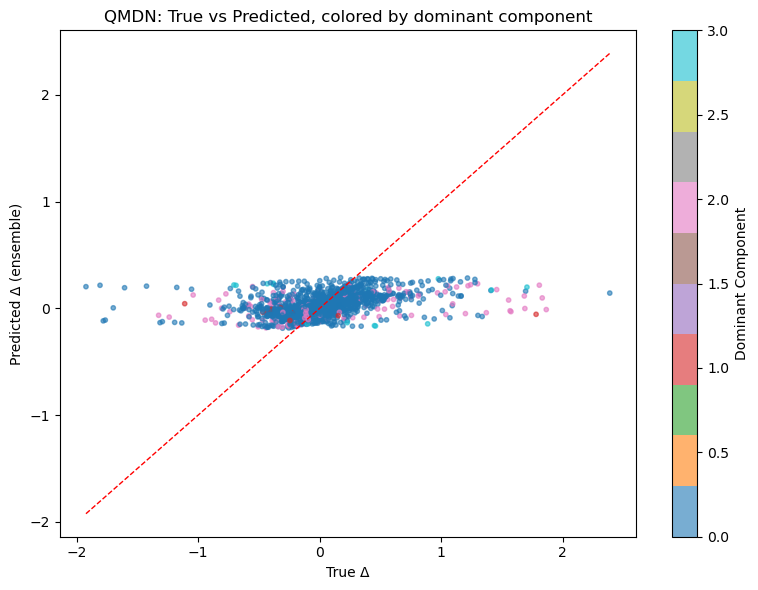

In [13]:
plt.figure(figsize=(8,6))
sc = plt.scatter(y_all, pred_delta_ensemble, c=dominant_component, cmap='tab10', alpha=0.6, s=10)
plt.plot([y_all.min(), y_all.max()], [y_all.min(), y_all.max()], 'r--', lw=1)
plt.colorbar(sc, label='Dominant Component')
plt.xlabel('True Δ')
plt.ylabel('Predicted Δ (ensemble)')
plt.title('QMDN: True vs Predicted, colored by dominant component')
plt.tight_layout()
plt.show()

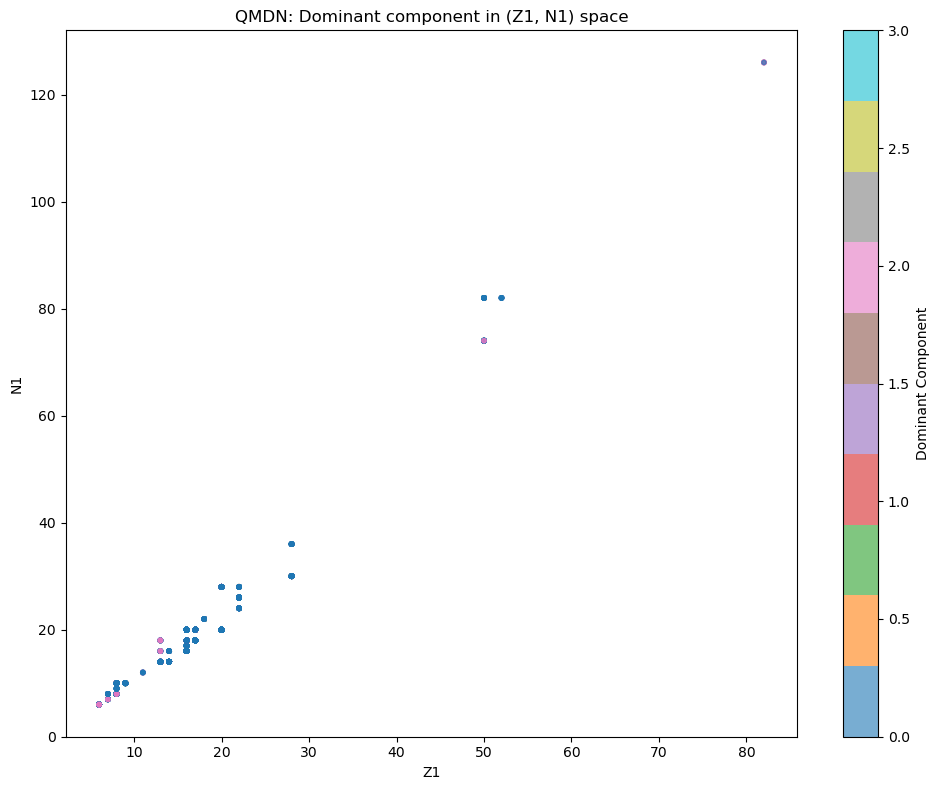

In [14]:
plt.figure(figsize=(10,8))
sc = plt.scatter(df['Z1'], df['N1'], c=dominant_component, cmap='tab10', alpha=0.6, s=10)
plt.colorbar(sc, label='Dominant Component')
plt.xlabel('Z1')
plt.ylabel('N1')
plt.title('QMDN: Dominant component in (Z1, N1) space')
plt.tight_layout()
plt.show()

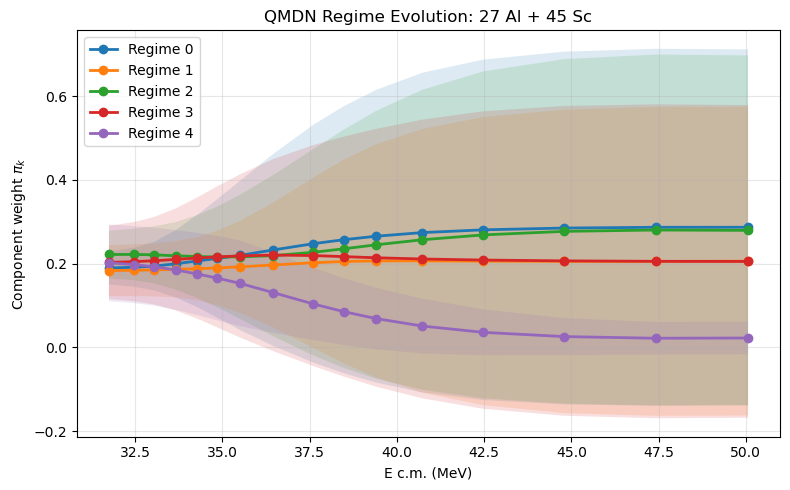

In [23]:
# ========================================================================
# PLOT: QMDN REGIME EVOLUTION FOR A SINGLE REACTION
# ========================================================================
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import joblib
import os

# ---------- Configuration ----------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reaction of interest (change to any reaction in your dataset)
reaction_name = "27 Al + 45 Sc"    # <<---- CHANGE THIS

# QMDN ensemble directory (set in your training notebook)
EN_DIR = "mdn_70_10_20_optimized/qmdn_ensembles_fast"   # adjust if needed

# Number of mixture components (should be 5 as per your config)
N_COMPONENTS = 5

# ---------- Load scaler ----------
scaler = joblib.load(os.path.join(EN_DIR, "scaler.pkl"))

# ---------- Get rows for this reaction ----------
rows_R = df[df["Reaction"] == reaction_name].copy()
if len(rows_R) == 0:
    raise ValueError(f"Reaction '{reaction_name}' not found in dataframe.")

rows_R = rows_R.sort_values("E c.m.").reset_index(drop=True)

X_R = rows_R[features_train].values.astype(np.float32)
E_R = rows_R["E c.m."].values

# Scale input
X_Rs = scaler.transform(X_R)

# ---------- Load all seed π values ----------
pi_all = []   # list of (n_points, n_components)

for s in SEEDS:   # SEEDS list defined earlier (e.g., [42,...,51])
    path = os.path.join(EN_DIR, f"seed_{s}", "full_components.npz")
    if not os.path.exists(path):
        print(f"Warning: {path} not found. Skipping seed {s}.")
        continue
    data = np.load(path)
    pi = data["pi"]   # shape (full_dataset, n_components)

    # Extract indices for this reaction
    idx = df[df["Reaction"] == reaction_name].index
    pi_R = pi[idx]     # shape (n_points, n_components)
    pi_all.append(pi_R)

if len(pi_all) == 0:
    raise RuntimeError("No seed data loaded. Check paths and SEEDS list.")

pi_all = np.stack(pi_all, axis=0)   # (n_seeds, n_points, n_components)
pi_mean = pi_all.mean(axis=0)
pi_std  = pi_all.std(axis=0)

# ---------- Plot π_k(E) ----------
plt.figure(figsize=(8,5))

for k in range(N_COMPONENTS):
    plt.plot(E_R, pi_mean[:, k], marker='o', linewidth=2, label=f"Regime {k}")
    plt.fill_between(E_R,
                     pi_mean[:, k] - pi_std[:, k],
                     pi_mean[:, k] + pi_std[:, k],
                     alpha=0.15)

plt.xlabel("E c.m. (MeV)")
plt.ylabel("Component weight $\\pi_k$")
plt.title(f"QMDN Regime Evolution: {reaction_name}")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

# Save high‑resolution figure
filename = f"qmdn_regime_evolution_{reaction_name.replace(' ', '_').replace('+', 'plus')}.png"
plt.savefig(filename, dpi=1000)
plt.show()

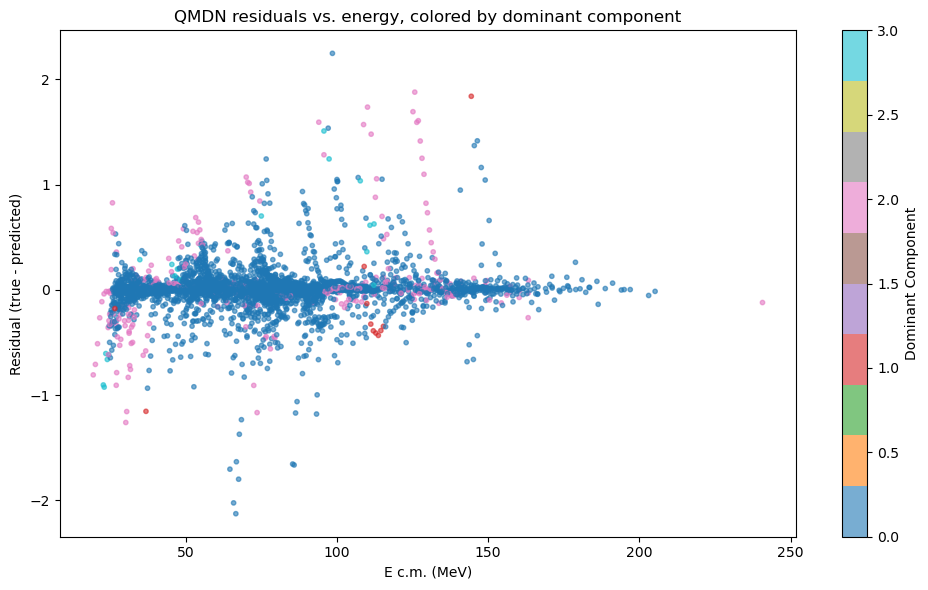

In [17]:
plt.figure(figsize=(10,6))
sc = plt.scatter(df['E c.m.'], residuals, c=dominant_component, cmap='tab10', alpha=0.6, s=10)
plt.colorbar(sc, label='Dominant Component')
plt.xlabel('E c.m. (MeV)')
plt.ylabel('Residual (true - predicted)')
plt.title('QMDN residuals vs. energy, colored by dominant component')
plt.tight_layout()
plt.show()

In [26]:

CLASSICAL_EN_DIR = "mdn_70_10_20_optimized/ensembles_fast"
QMDN_EN_DIR = "mdn_70_10_20_optimized/qmdn_ensembles_fast"
# Load full-dataset components for classical MDN
pi_class_all = []
for s in SEEDS:
    path = os.path.join(CLASSICAL_EN_DIR, f"seed_{s}", "mdn_all_components.npz")
    data = np.load(path)
    pi_class_all.append(data["pi"])
pi_class_all = np.stack(pi_class_all, axis=0)   # (n_seeds, n_points, n_components)
pi_class_mean_all = pi_class_all.mean(axis=0)    # (n_points, n_components)

# Load full-dataset components for QMDN
pi_qmdn_all = []
for s in SEEDS:
    path = os.path.join(QMDN_EN_DIR, f"seed_{s}", "full_components.npz")
    data = np.load(path)
    pi_qmdn_all.append(data["pi"])
pi_qmdn_all = np.stack(pi_qmdn_all, axis=0)
pi_qmdn_mean_all = pi_qmdn_all.mean(axis=0)

# Now compute dominant components
dom_class_all = np.argmax(pi_class_mean_all, axis=1)
dom_qmdn_all  = np.argmax(pi_qmdn_mean_all, axis=1)

# Optional: restrict to a specific reaction using global indices
global_idx = df[df["Reaction"] == reaction_name].index
dom_class_reaction = dom_class_all[global_idx]
dom_qmdn_reaction  = dom_qmdn_all[global_idx]
E_vals = df.loc[global_idx, "E c.m."].values

# Plot as above

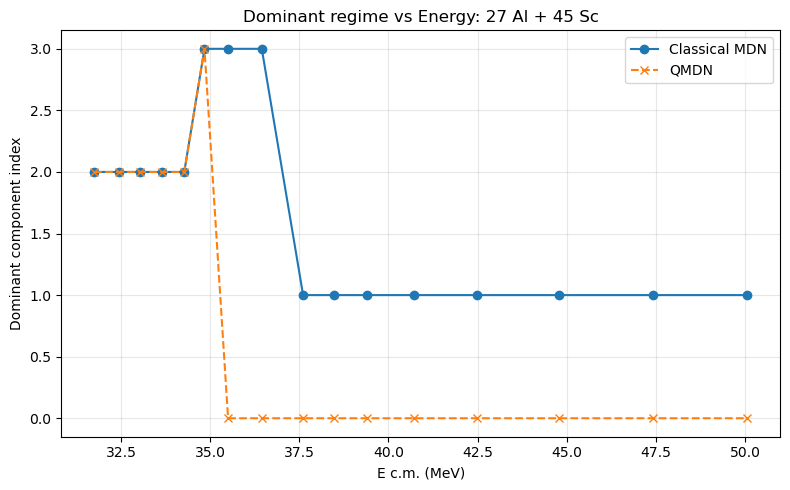

In [28]:
# Get global indices for the reaction
global_idx = df[df["Reaction"] == reaction_name].index

# Extract data for this reaction
dom_class_reaction = np.argmax(pi_class_mean_all[global_idx], axis=1)
dom_qmdn_reaction  = np.argmax(pi_qmdn_mean_all[global_idx], axis=1)
E_vals = df.loc[global_idx, "E c.m."].values

# Sort by energy for clean plotting
sort_idx = np.argsort(E_vals)
E_sorted = E_vals[sort_idx]
dom_class_sorted = dom_class_reaction[sort_idx]
dom_qmdn_sorted  = dom_qmdn_reaction[sort_idx]

plt.figure(figsize=(8,5))
plt.plot(E_sorted, dom_class_sorted, marker='o', label='Classical MDN', linestyle='-')
plt.plot(E_sorted, dom_qmdn_sorted, marker='x', label='QMDN', linestyle='--')
plt.xlabel("E c.m. (MeV)")
plt.ylabel("Dominant component index")
plt.title(f"Dominant regime vs Energy: {reaction_name}")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Loading classical MDN components...
Loading QMDN components...


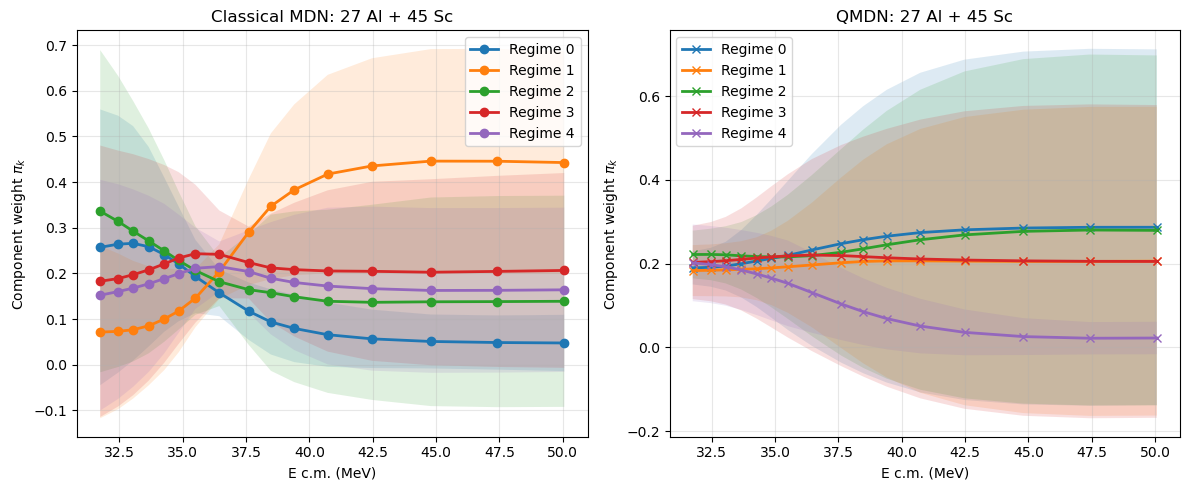

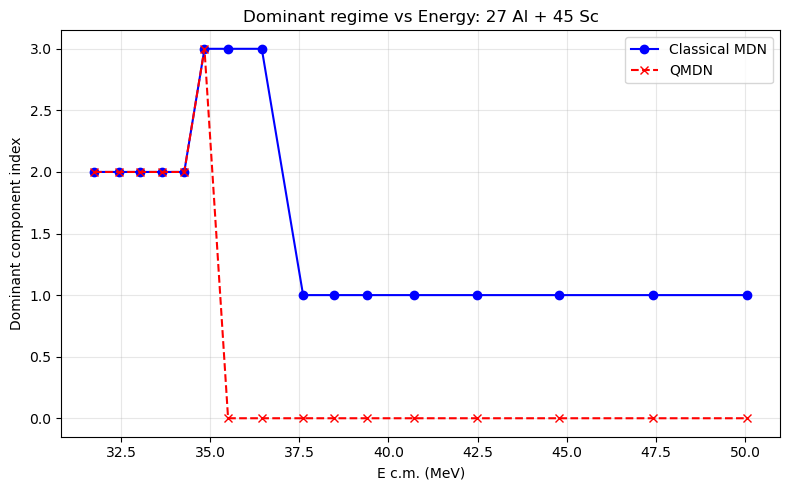

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import os

# ---------- Specify the reaction ----------
reaction_name = "27 Al + 45 Sc"   # <<-- change to any reaction in your dataset

# ---------- Helper: load component weights for a given reaction ----------
def load_pi_for_reaction(ensemble_dir, file_pattern, reaction_name, seeds, df):
    # Get global indices for this reaction
    global_idx = df[df["Reaction"] == reaction_name].index
    if len(global_idx) == 0:
        raise ValueError(f"Reaction '{reaction_name}' not found.")
    # Sort by energy for later plotting
    reaction_rows = df.loc[global_idx].sort_values("E c.m.")
    global_idx_sorted = reaction_rows.index
    E_vals = reaction_rows["E c.m."].values

    pi_all = []
    for s in seeds:
        path = os.path.join(ensemble_dir, f"seed_{s}", file_pattern)
        if not os.path.exists(path):
            print(f"Warning: {path} not found, skipping seed {s}.")
            continue
        data = np.load(path)
        pi_full = data["pi"]          # shape (full_dataset, n_components)
        pi_reaction = pi_full[global_idx_sorted]   # sorted by energy
        pi_all.append(pi_reaction)

    if len(pi_all) == 0:
        raise RuntimeError(f"No data loaded for reaction {reaction_name} in {ensemble_dir}")

    pi_all = np.stack(pi_all, axis=0)      # (n_seeds, n_points, n_components)
    pi_mean = pi_all.mean(axis=0)
    pi_std  = pi_all.std(axis=0)
    return pi_mean, pi_std, E_vals

# ---------- Load data for both models ----------
print("Loading classical MDN components...")
pi_class_mean, pi_class_std, E_class = load_pi_for_reaction(
    CLASSICAL_EN_DIR, "mdn_all_components.npz", reaction_name, SEEDS, df
)

print("Loading QMDN components...")
pi_qmdn_mean, pi_qmdn_std, E_qmdn = load_pi_for_reaction(
    QMDN_EN_DIR, "full_components.npz", reaction_name, SEEDS, df
)

# ---------- Plot 1: π_k(E) curves (classical) ----------
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
for k in range(N_COMPONENTS):
    plt.plot(E_class, pi_class_mean[:, k], marker='o', linewidth=2, label=f"Regime {k}")
    plt.fill_between(E_class,
                     pi_class_mean[:, k] - pi_class_std[:, k],
                     pi_class_mean[:, k] + pi_class_std[:, k],
                     alpha=0.15)
plt.xlabel("E c.m. (MeV)")
plt.ylabel("Component weight $\\pi_k$")
plt.title(f"Classical MDN: {reaction_name}")
plt.legend()
plt.grid(alpha=0.3)

# ---------- Plot 2: π_k(E) curves (QMDN) ----------
plt.subplot(1,2,2)
for k in range(N_COMPONENTS):
    plt.plot(E_qmdn, pi_qmdn_mean[:, k], marker='x', linewidth=2, label=f"Regime {k}")
    plt.fill_between(E_qmdn,
                     pi_qmdn_mean[:, k] - pi_qmdn_std[:, k],
                     pi_qmdn_mean[:, k] + pi_qmdn_std[:, k],
                     alpha=0.15)
plt.xlabel("E c.m. (MeV)")
plt.ylabel("Component weight $\\pi_k$")
plt.title(f"QMDN: {reaction_name}")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ---------- Plot 3: Dominant component vs Energy (overlay) ----------
dom_class = np.argmax(pi_class_mean, axis=1)
dom_qmdn  = np.argmax(pi_qmdn_mean, axis=1)

plt.figure(figsize=(8,5))
plt.plot(E_class, dom_class, marker='o', linestyle='-', label='Classical MDN', color='blue')
plt.plot(E_qmdn, dom_qmdn, marker='x', linestyle='--', label='QMDN', color='red')
plt.xlabel("E c.m. (MeV)")
plt.ylabel("Dominant component index")
plt.title(f"Dominant regime vs Energy: {reaction_name}")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()